## Wombat Jun16z Wed Poly Maude Rise wind isolation 3yr perturbation

In [1]:
# Load modules
%pylab inline
from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from os.path import expanduser
home = expanduser("~") # Get users home directory
import os # operating system interface
import scipy as sp
import xarray as xr
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage




Populating the interactive namespace from numpy and matplotlib


In [2]:
#extract the MOM model grid info - 50 and 75 vertical levels
hgrid_file ='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/mom025_ocean_grid.nc'
vgrid_file ='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/ocean.ncra501-520.nc'

# Extract the variables
nc = Dataset(hgrid_file, mode='r') # file handle, open in read only mode
geolon_t = nc.variables['geolon_t'][:]
geolat_t = nc.variables['geolat_t'][:]
area_t = nc.variables['area_t'][:]
dxt = nc.variables['dxt'][:]
dyt = nc.variables['dyt'][:]
kmu = nc.variables['kmu'][:]
kmt = nc.variables['kmt'][:]
ht = nc.variables['ht'][:]
fcor = nc.variables['f_coriolis'][:]
nc.close() # close the file
print geolon_t.shape

fh=fcor/ht
print fh.shape

nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
sw_ocean = nc.variables['sw_ocean'][:]
st_ocean = nc.variables['st_ocean'][:]
yt_ocean = nc.variables['yt_ocean'][:]
yu_ocean = nc.variables['yu_ocean'][:]
xt_ocean = nc.variables['xt_ocean'][:]
potrho = nc.variables['potrho'][:]
nc.close() # close the file
print st_ocean.shape
print potrho.shape
print yt_ocean.shape


(1080, 1440)
(1080, 1440)
(50,)
(80,)
(1080,)


In [3]:
#A = xr.DataArray(np.arange(100))
#A.cumsum(axis=0)
print (xr.__version__)

#my xarray version is old, no cumsum. Should be version 0.9.2 or newer?

0.10.0


In [4]:
NYFCntrlDir = '/g/data1/v45/pas561/mom/archive/wombat_jun16z/'
#this has 3 years of a wind perturbation - get a nice 3 year polynya.
NYFPertDir = '/g/data1/v45/pas561/mom/archive/wombat_jun16z_wp2/'


In [12]:

Ocean_File = os.path.join(NYFCntrlDir,'output197*/ocean_force*.nc')
print Ocean_File
cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)

Ocean_File = os.path.join(NYFPertDir,'output19*/ocean_force*.nc')
print Ocean_File
pert=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)


/g/data1/v45/pas561/mom/archive/wombat_jun16z/output197*/ocean_force*.nc
/g/data1/v45/pas561/mom/archive/wombat_jun16z_wp2/output19*/ocean_force*.nc


In [13]:
#plot wind stress
print cntrl.tau_x.shape
#cntrl_tx=ff.tau_x.load()
#cntrl_ty=ff.tau_y.load()

print pert.tau_x.shape
#pert_tx=ff.tau_x.load()
#pert_ty=ff.tau_y.load()
#print pert_tx.shape

(108, 1080, 1440)
(348, 1080, 1440)


(1080, 1440)


/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


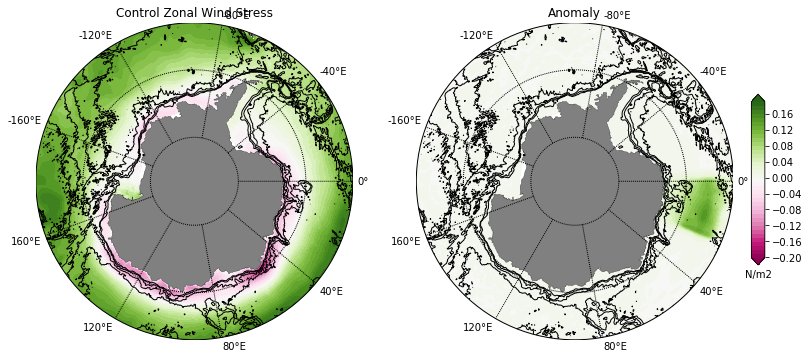

In [8]:

print pert.tau_x[0].shape

plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.suptitle('Wind Stress')

clev = np.arange(-.2,.2,.01)

plt.subplot(1,2,1)
map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,cntrl.tau_x[0:12,:,:].mean('time').load(), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('N/m2')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht,levels=clev3,colors='k',linewidths=1)
plt.title('Control Zonal Wind Stress')

#clev = np.arange(-.1,.1,.01)

plt.subplot(1,2,2)
map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,pert.tau_x[0:12,:,:].mean('Time').load()-cntrl.tau_x[0:12,:,:].mean('time').load(), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#cb=plt.colorbar(orientation='vertical',shrink = 0.5)
#cb.ax.set_xlabel('N/m2')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht,levels=clev3,colors='k',linewidths=1)
plt.title('Anomaly')

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('N/m2')

#of = os.path.join(NYFPertDir,'tau_x.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'tau_x.png')
plt.savefig(of,dpi=220)


Text(0.5,0,u'N/m^2')

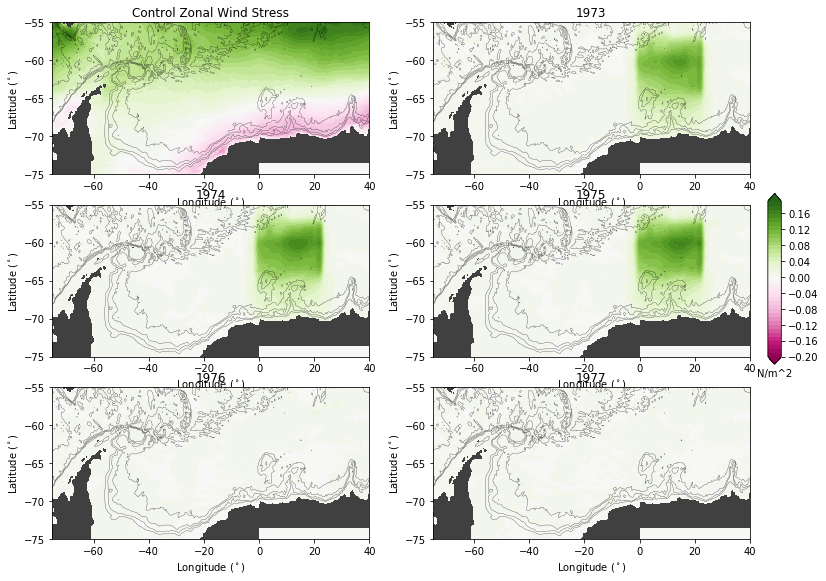

In [9]:
clev = np.arange(-.2,.2,.01)
clev3 = np.arange(0,5000,1000)

plt.subplot(321)
plt.gca().patch.set_color('.25')
p1=plt.contourf(xt_ocean,yt_ocean,cntrl.tau_x[0:12,:,:].mean('time').load(),cmap=plt.cm.PiYG,levels=clev,extend='both')
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('N/m^2')
clev3 = np.arange(0,5000,1000)
plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-55))
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.xlim([-75,40])
plt.title('Control Zonal Wind Stress')


yrs=np.arange(1973,2016,1)

ii=0
for yr in range(0,5):
    
    #print yr*12, yr*12+12
        
    plt.subplot(3,2,yr+2)
    plt.gca().patch.set_color('.25')
    p1=plt.contourf(xt_ocean,yt_ocean,pert.tau_x[yr*12:yr*12+12,:,:].mean('Time').load()-cntrl.tau_x[yr*12:yr*12+12,:,:].mean('time').load(),cmap=plt.cm.PiYG,levels=clev,extend='both')
    #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    #cb.ax.set_xlabel('N/m^2')
    clev3 = np.arange(0,5000,1000)
    plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
    plt.gca().yaxis.set_major_formatter(x_formatter)
    plt.ylim((-75,-55))
    plt.xlabel('Longitude ($^\circ$)')
    plt.ylabel('Latitude ($^\circ$)')
    plt.xlim([-75,40])
    plt.title(yrs[yr].astype('S4'))
    
    #ii+=12
    
ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('N/m^2')

#of = os.path.join(NYFPertDir,'wpm2_cn.pdf')
#print of
#plt.savefig(of)
#of = os.path.join(NYFPertDir,'wpm2_cn.png')
#plt.savefig(of,dpi=220)


In [10]:
#plot wind stress curl ... Ekman pumping anomalies.
#(d(Tau_y/f) /dx - d(Tau_x/f) / dy) /rho_0

#drhodx=np.gradient(rho[0,:,:,:],dxt,axis=2)
#print drhodx.shape

print cntrl.tau_x.shape
cntrl_Txf=cntrl.tau_x[0:12,:,:].mean('time').load()/fcor
cntrl_Tyf=cntrl.tau_y[0:12,:,:].mean('time').load()/fcor
print cntrl_Txf.shape

cntrl_dTyfdx=np.gradient(cntrl_Tyf,dxt,axis=1)
print cntrl_dTyfdx.shape
cntrl_dTxfdy=np.gradient(cntrl_Txf,dyt,axis=0)
print cntrl_dTxfdy.shape

rho0=1035.0
cntrl_we=(cntrl_dTyfdx-cntrl_dTxfdy)/rho0


print pert.tau_x.shape
pert_Txf=pert.tau_x[0:12,:,:].mean('Time').load()/fcor
pert_Tyf=pert.tau_y[0:12,:,:].mean('Time').load()/fcor
print pert_Tyf.shape

pert_dTyfdx=np.gradient(pert_Tyf,dxt,axis=1)
print pert_dTyfdx.shape
pert_dTxfdy=np.gradient(pert_Txf,dyt,axis=0)
print pert_dTxfdy.shape

rho0=1035.0
pert_we=(pert_dTyfdx-pert_dTxfdy)/rho0



(108, 1080, 1440)
(1080, 1440)
(1080, 1440)
(1080, 1440)
(348, 1080, 1440)
(1080, 1440)
(1080, 1440)
(1080, 1440)


In [11]:
m=np.nanmax(cntrl_we[0:300,:])
print m
m=np.nanmin(cntrl_we[0:300,:])
print m

m=np.nanmax(pert_we[0:300,:])
print m
m=np.nanmin(pert_we[0:300,:])
print m

#convert from m/s to m/day
s_day=60*60*24
print s_day
cntrl_we=cntrl_we*s_day
pert_we=pert_we*s_day

m=np.nanmax(cntrl_we[0:300,:])
print m
m=np.nanmin(cntrl_we[0:300,:])
print m

m=np.nanmax(pert_we[0:300,:])
print m
m=np.nanmin(pert_we[0:300,:])
print m


5.95872585237e-05
-5.08694792028e-05
5.96054007596e-05
-5.08209387875e-05
86400
5.14833913645
-4.39512300312
5.14990662563
-4.39092911124


In [12]:
print cntrl_we.shape

(1080, 1440)


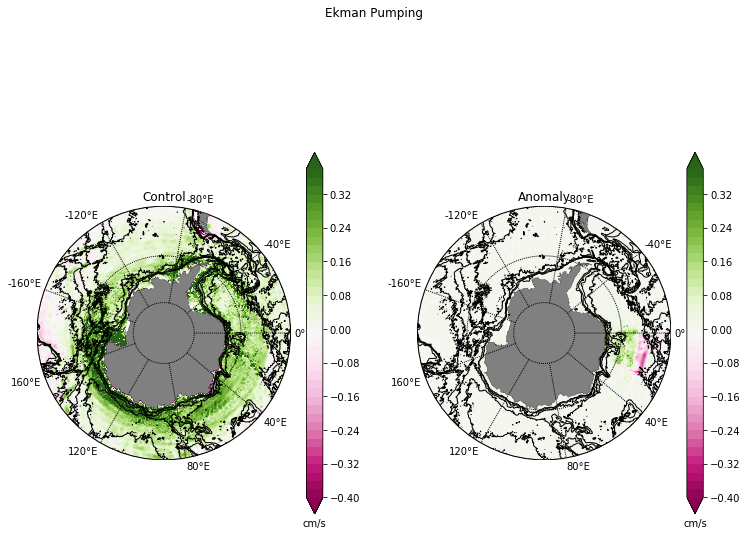

In [13]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Ekman Pumping')
clev = np.arange(-.4,.4,.02)

plt.subplot(1,2,1)
map = Basemap(projection='spstere',boundinglat=-50,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,cntrl_we, cmap=plt.cm.PiYG, levels=clev,extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('cm/s')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht,levels=clev3,colors='k',linewidths=1)
plt.title('Control')


plt.subplot(1,2,2)
map = Basemap(projection='spstere',boundinglat=-50,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,pert_we-cntrl_we, cmap=plt.cm.PiYG, levels=clev,extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('cm/s')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht,levels=clev3,colors='k',linewidths=1)
plt.title('Anomaly')


#of = os.path.join(NYFPertDir,'we.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'we.png')
plt.savefig(of,dpi=220)


In [14]:
#plot stamps of sea ice concentration.
Ocean_File = os.path.join(NYFCntrlDir,'output197*/ice__*.nc')
cntrl_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print cntrl_i.CN.shape
#nyf_cn=ff.CN.sum('ct').load()
#print nyf_cn.shape

Ocean_File = os.path.join(NYFPertDir,'output19*/ice__*.nc')
pert_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print pert_i.CN.shape
#pert_cn=ff.CN.sum('ct').load()
#print pert_cn.shape

#print nyf_cn.shape
#print pert_cn.shape
#cn = np.concatenate((nyf_cn[0:12,:],pert_cn),axis=0)
#print cn.shape


(108, 5, 1080, 1440)
(348, 5, 1080, 1440)


['June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.']


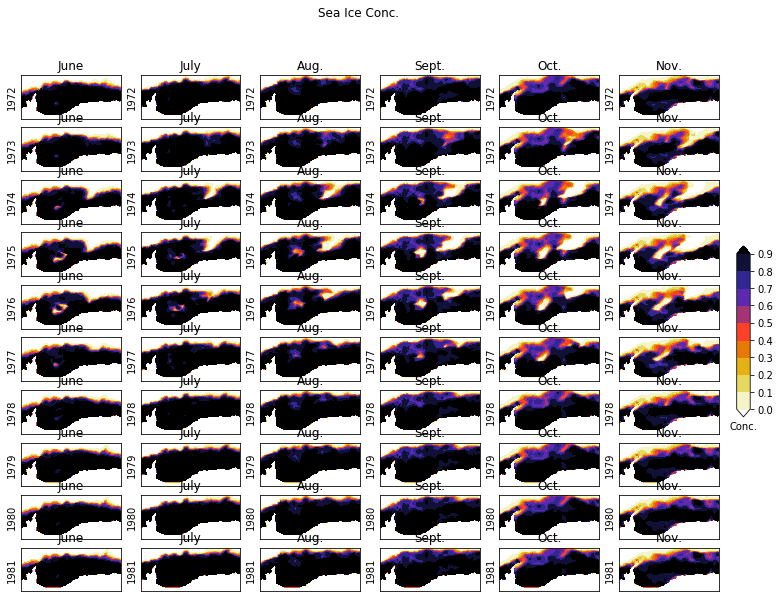

In [15]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Sea Ice Conc.')

tits=['June','July','Aug.','Sept.','Oct.', 'Nov.']
yrs=np.arange(1972,2016,1)
print tits


ii=0
for yr in range(0,10):
    #print yr
    for i in range(5,11): 
        
        #print yr*12+i
    
        clev = np.arange(0,1,.1)
        plt.subplot(10,6,ii+1)
        plt.gca().patch.set_color('.25')
        
        if yr==0:
            p1=plt.contourf(xt_ocean,yt_ocean,cntrl_i.CN[yr*12+i,:,:].sum('ct').load(),cmap=plt.cm.CMRmap_r,levels=clev,extend='both')
        else:
            p1=plt.contourf(xt_ocean,yt_ocean,pert_i.CN[(yr-1)*12+i,:,:].sum('ct').load(),cmap=plt.cm.CMRmap_r,levels=clev,extend='both')
            
        #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
        #cb.ax.set_xlabel('Conc.')
        #clev3 = np.arange(0,5000,1000)
        #plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
        plt.gca().yaxis.set_major_formatter(x_formatter)
        plt.ylim((-80,-55))
        #plt.xlabel('Longitude ($^\circ$)')
        plt.ylabel(yrs[yr])
        plt.xlim([-80,40])
        plt.title(tits[i-5])     
        plt.gca().axes.get_xaxis().set_ticks([])
        plt.gca().axes.get_yaxis().set_ticks([])
        
        ii+=1

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Conc.')

#of = os.path.join(NYFPertDir,'cn.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'cn.png')
plt.savefig(of,dpi=220)


In [8]:

Ocean_File = os.path.join(NYFCntrlDir,'output197*/ocean__*.nc')
print Ocean_File
cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print cntrl.mld.shape

Ocean_File = os.path.join(NYFPertDir,'output19*/ocean__*.nc')
print Ocean_File
pert=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print pert.mld.shape

/g/data1/v45/pas561/mom/archive/wombat_jun16z/output197*/ocean__*.nc
/g/data1/v45/pas561/mom/archive/wombat_jun16z_wp2/output19*/ocean__*.nc


In [10]:
print cntrl.mld.shape
print pert.mld.shape

(9, 1080, 1440)
(29, 1080, 1440)


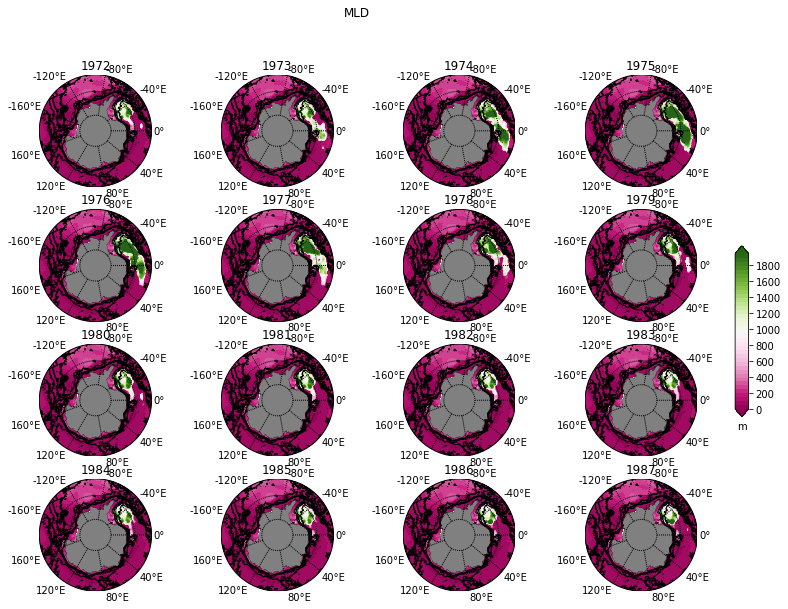

In [19]:
#plot MLD
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('MLD')
clev = np.arange(0,2000,50)
yrs=np.arange(1972,2016,1)

plt.subplot(4,4,1)
map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,cntrl.mld[0].load(), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('N/m2')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht,levels=clev3,colors='k',linewidths=1)
plt.title(yrs[0])


ii=0
for yr in range(0,15):
    #print yr

    plt.subplot(4,4,yr+2)
    map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    map.drawparallels(np.arange(-80.,81.,15.))
    map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
    X, Y = map(geolon_t,geolat_t) 
    p1=map.contourf(X,Y,pert.mld[yr].load(), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
    #cb=plt.colorbar(orientation='vertical',shrink = 0.5)
    #cb.ax.set_xlabel('N/m2')
    clev3 = np.arange(0,5000,1000)
    map.contour(X,Y,ht,levels=clev3,colors='k',linewidths=1)
    plt.title(yrs[yr+1])

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('m')

#of = os.path.join(NYFPertDir,'mld.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'mld.png')
plt.savefig(of,dpi=220)


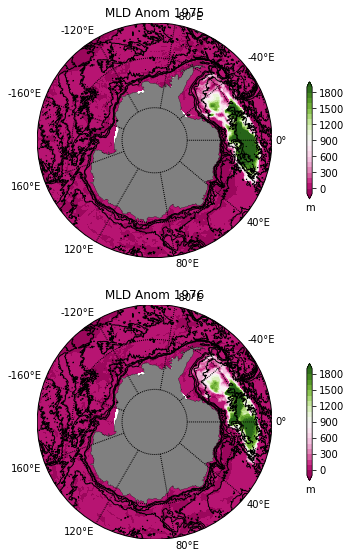

In [21]:
clev = np.arange(-100,2000,100)
plt.subplot(2,1,1)
map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,pert.mld[2].load()-cntrl.mld[2].load(), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.5)
cb.ax.set_xlabel('m')
clev3 = np.arange(1000,5001,1000)
map.contour(X,Y,ht,levels=clev3,colors='k',linewidths=1)
plt.title('MLD Anom 1975')

plt.subplot(2,1,2)
map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,pert.mld[3].load()-cntrl.mld[3].load(), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.5)
cb.ax.set_xlabel('m')
clev3 = np.arange(1000,5001,1000)
map.contour(X,Y,ht,levels=clev3,colors='k',linewidths=1)
plt.title('MLD Anom 1976')

#of = os.path.join(NYFPertDir,'mld_1975anom.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'mld_1975anom.png')
plt.savefig(of,dpi=220)

## Calc the GMOC from ty_trans_rho 

In [22]:
print pert.ty_trans_rho.shape

pert_gmoc=pert.ty_trans_rho[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()

print pert_gmoc.shape

of=os.path.join(NYFPertDir,'gmoc_rho.npy')
a=np.save(of,pert_gmoc)



(29, 80, 1080, 1440)
(29, 80, 1080)


In [23]:
print cntrl.ty_trans_rho.shape

cntrl_gmoc=cntrl.ty_trans_rho[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()

print cntrl_gmoc.shape

of=os.path.join(NYFCntrlDir,'gmoc_rho.npy')
a=np.save(of,cntrl_gmoc)


(9, 80, 1080, 1440)
(9, 80, 1080)


In [24]:
#load gmoc in rho space
of=os.path.join(NYFPertDir,'gmoc_rho.npy')
pert_gmoc=np.load(of)
print pert_gmoc.shape

#of=os.path.join(NYFCntrlDir,'cntrl_gmocs.npy')
of=os.path.join(NYFCntrlDir,'gmoc_rho.npy')
cntrl_gmoc=np.load(of)
print cntrl_gmoc.shape



(29, 80, 1080)
(9, 80, 1080)


In [9]:
print cntrl.ty_trans_rho_gm.shape
cntrl_gmoc_gm=cntrl.ty_trans_rho_gm[:,:,:,:].sum('grid_xt_ocean').load()
print cntrl_gmoc_gm.shape
of=os.path.join(NYFCntrlDir,'gmoc_rho_gm.npy')
a=np.save(of,cntrl_gmoc_gm)

(9, 80, 1080, 1440)
(9, 80, 1080)


In [15]:
print pert.ty_trans_rho_gm.shape
pert_gmoc_gm=pert.ty_trans_rho_gm[:,:,:,:].sum('grid_xt_ocean').load()
print pert_gmoc_gm.shape
of=os.path.join(NYFPertDir,'gmoc_rho_gm.npy')
a=np.save(of,pert_gmoc_gm)

(29, 80, 1080, 1440)
(29, 80, 1080)


In [13]:
yrs=np.arange(1973,2016,1)
print yrs
print yrs.astype('S4')

[1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
['1973' '1974' '1975' '1976' '1977' '1978' '1979' '1980' '1981' '1982'
 '1983' '1984' '1985' '1986' '1987' '1988' '1989' '1990' '1991' '1992'
 '1993' '1994' '1995' '1996' '1997' '1998' '1999' '2000' '2001' '2002'
 '2003' '2004' '2005' '2006' '2007' '2008' '2009' '2010' '2011' '2012'
 '2013' '2014' '2015']


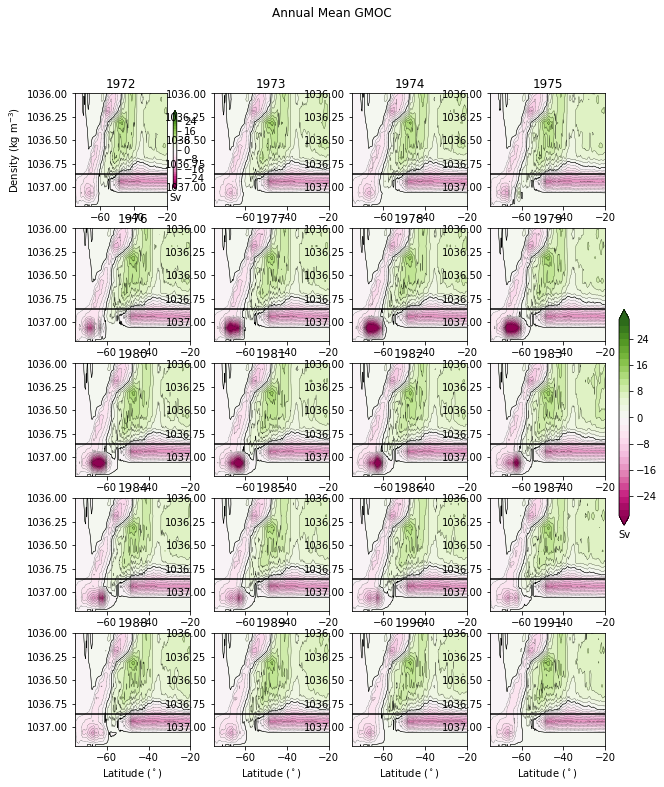

In [27]:
#plot gmoc in rho space
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Annual Mean GMOC')
clev = np.arange(-30,32,2)

t1=0
t2=5

plt.subplot(541)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.2,1036))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-75,-20])
tit='1972'
plt.title(tit)
plt.plot([-75,-20], [1036.86,1036.86], 'k')


ii=0
for yr in range(0,19):
    
    #np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0)
    plt.subplot(5,4,yr+2)
    p1=plt.contourf(yu_ocean,potrho,pert_gmoc[yr,:,:],cmap=plt.cm.PiYG,levels=clev,extend='both')
    #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    #cb.ax.set_xlabel('Sv')
    plt.contour(yu_ocean,potrho,pert_gmoc[yr,:,:],levels=clev,colors='k',linewidths=0.25)
    plt.contour(yu_ocean,potrho,pert_gmoc[yr,:,:],levels=[0.0,],colors='k',linewidths=0.5)
    plt.gca().invert_yaxis()
    plt.gca().yaxis.set_major_formatter(x_formatter)
    plt.ylim((1037.2,1036))
    #plt.ylabel('Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$)')
    plt.xlim([-75,-20])
    tit=yrs[yr].astype('S4')
    plt.title(yrs[yr])
    plt.plot([-75,-20], [1036.86,1036.86], 'k')


ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Sv')

#of = os.path.join(NYFPertDir,'wpm2_cn.pdf')
#print of
#plt.savefig(of)
#of = os.path.join(NYFPertDir,'wpm2_cn.png')
#plt.savefig(of,dpi=220)
#of = os.path.join(NYFPertDir,'gmoc.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'gmoc.png')
plt.savefig(of,dpi=220)

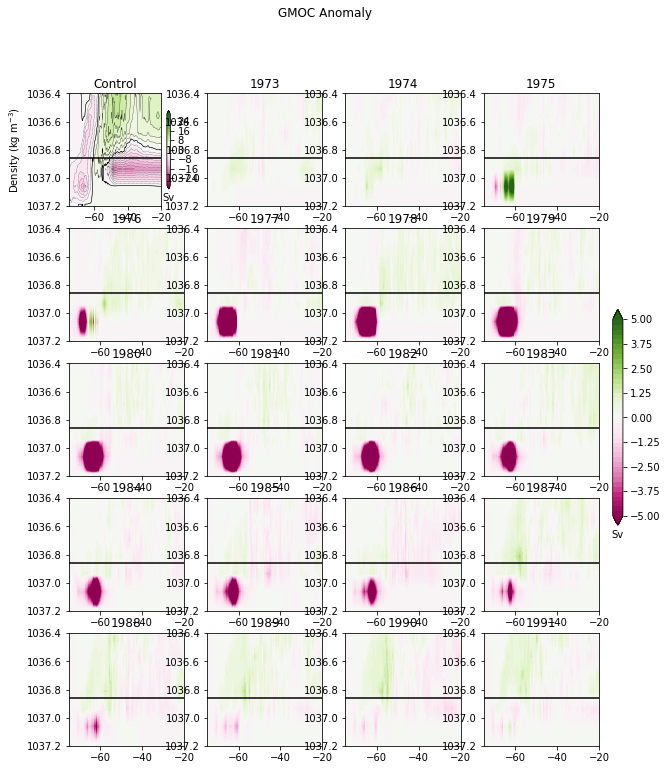

In [29]:
#plot gmoc anom in rho space
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('GMOC Anomaly')

clev = np.arange(-30,32,2)

t1=0
t2=5

plt.subplot(541)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.2,1036.4))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-75,-20])
tit='Control'
plt.title(tit)
plt.plot([-75,-20], [1036.86,1036.86], 'k')

yrs=np.arange(1973,2016,1)

ii=0

clev = np.arange(-5,5.25,0.25)


for yr in range(0,19):
    
    #np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0)
    plt.subplot(5,4,yr+2)
    p1=plt.contourf(yu_ocean,potrho,pert_gmoc[yr,:,:]-np.mean(cntrl_gmoc[:,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
    #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    #cb.ax.set_xlabel('Sv')
    #plt.contour(yu_ocean,potrho,pert_gmoc[yr,:,:]-cntrl_gmoc[yr,:,:],levels=clev,colors='k',linewidths=0.25)
    #plt.contour(yu_ocean,potrho,pert_gmoc[yr,:,:]-cntrl_gmoc[yr,:,:],levels=[0.0,],colors='k',linewidths=0.5)
    plt.gca().invert_yaxis()
    plt.gca().yaxis.set_major_formatter(x_formatter)
    plt.ylim((1037.2,1036.4))
    #plt.ylabel('Density (kg m$^{-3}$)')
    #plt.xlabel('Latitude ($^\circ$)')
    plt.xlim([-75,-20])
    tit='Anom. ' + yrs[yr].astype('S4')
    plt.title(yrs[yr].astype('S4'))
    plt.plot([-75,-20], [1036.86,1036.86], 'k')

    
ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Sv')

#of = os.path.join(NYFPertDir,'wpm2_cn.pdf')
#print of
#plt.savefig(of)
#of = os.path.join(NYFPertDir,'wpm2_cn.png')
#plt.savefig(of,dpi=220)
#of = os.path.join(NYFPertDir,'gmoc_anom.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'gmoc_anom.png')
plt.savefig(of,dpi=220)

/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


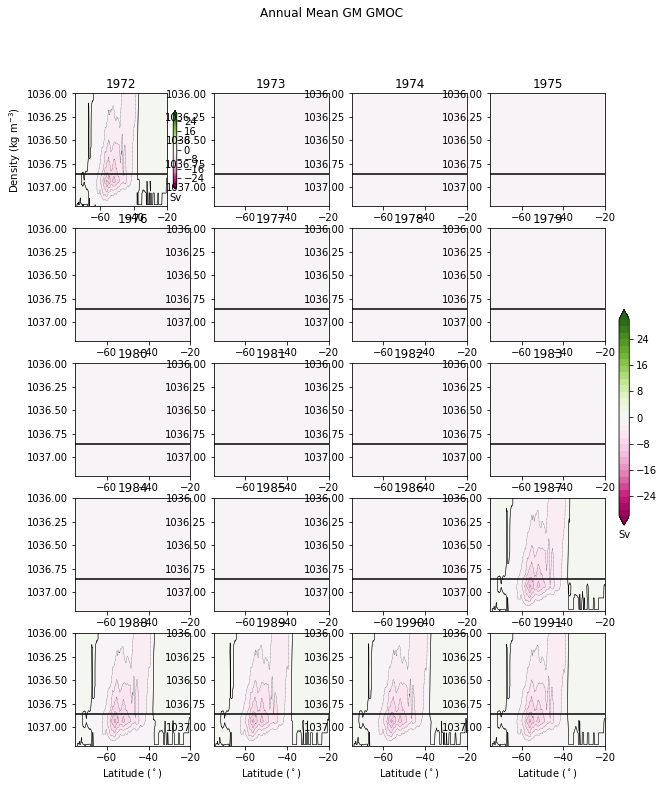

In [16]:
#plot GM gmoc in rho space
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Annual Mean GM GMOC')
clev = np.arange(-30,32,2)

t1=0
t2=5

plt.subplot(541)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_gmoc_gm[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc_gm[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc_gm[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.2,1036))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-75,-20])
tit='1972'
plt.title(tit)
plt.plot([-75,-20], [1036.86,1036.86], 'k')


ii=0
for yr in range(0,19):
    
    #np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0)
    plt.subplot(5,4,yr+2)
    p1=plt.contourf(yu_ocean,potrho,pert_gmoc_gm[yr,:,:],cmap=plt.cm.PiYG,levels=clev,extend='both')
    #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    #cb.ax.set_xlabel('Sv')
    plt.contour(yu_ocean,potrho,pert_gmoc_gm[yr,:,:],levels=clev,colors='k',linewidths=0.25)
    plt.contour(yu_ocean,potrho,pert_gmoc_gm[yr,:,:],levels=[0.0,],colors='k',linewidths=0.5)
    plt.gca().invert_yaxis()
    plt.gca().yaxis.set_major_formatter(x_formatter)
    plt.ylim((1037.2,1036))
    #plt.ylabel('Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$)')
    plt.xlim([-75,-20])
    tit=yrs[yr].astype('S4')
    plt.title(yrs[yr])
    plt.plot([-75,-20], [1036.86,1036.86], 'k')


ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Sv')

#of = os.path.join(NYFPertDir,'wpm2_cn.pdf')
#print of
#plt.savefig(of)
#of = os.path.join(NYFPertDir,'wpm2_cn.png')
#plt.savefig(of,dpi=220)
#of = os.path.join(NYFPertDir,'gmoc.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'gmoc_gm.png')
plt.savefig(of,dpi=220)

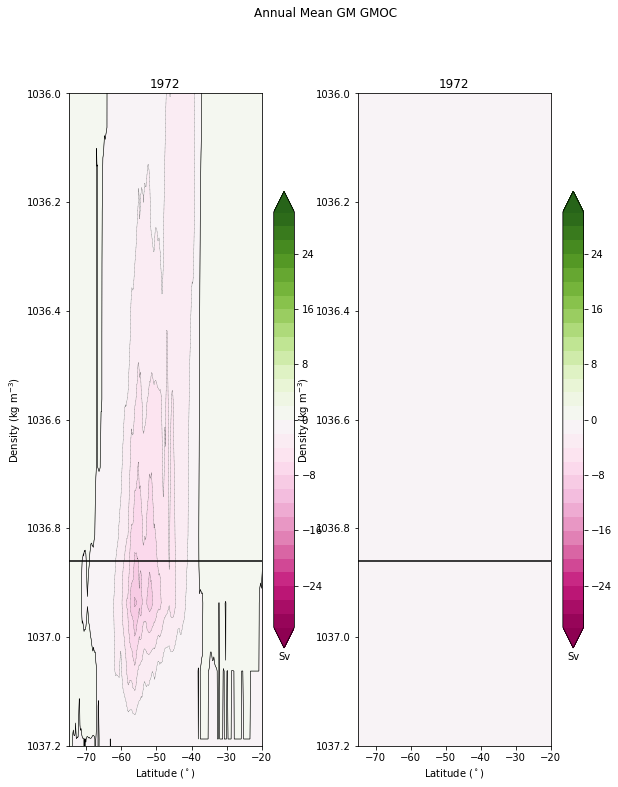

In [17]:
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Annual Mean GM GMOC')
clev = np.arange(-30,32,2)

t1=0
t2=5

plt.subplot(121)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_gmoc_gm[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc_gm[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc_gm[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.2,1036))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-75,-20])
tit='1972'
plt.title(tit)
plt.plot([-75,-20], [1036.86,1036.86], 'k')

plt.subplot(122)
plt.contourf(yu_ocean,potrho,np.mean(pert_gmoc_gm[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(pert_gmoc_gm[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(pert_gmoc_gm[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.2,1036))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-75,-20])
tit='1972'
plt.title(tit)
plt.plot([-75,-20], [1036.86,1036.86], 'k')

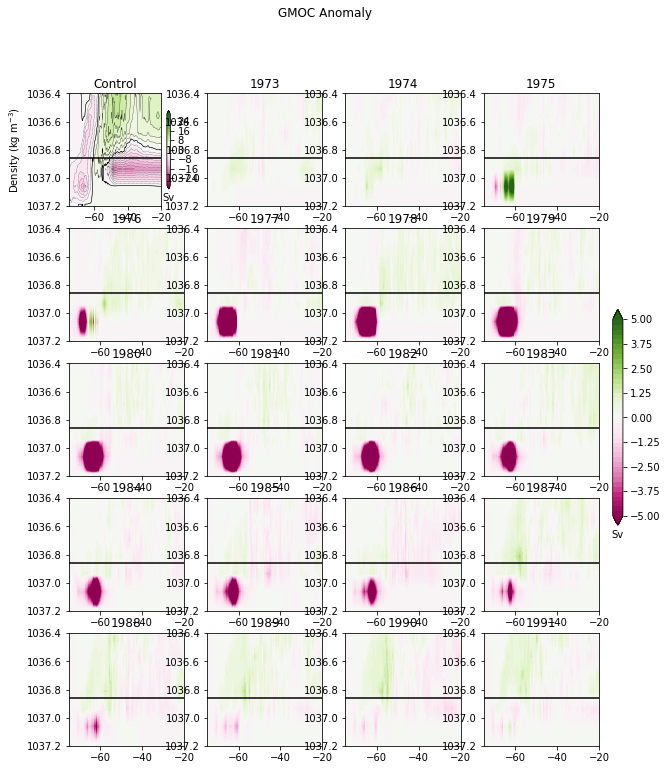

In [29]:
#plot gmoc anom in rho space
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('GMOC GM Anomaly')

clev = np.arange(-30,32,2)

t1=0
t2=5

plt.subplot(541)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_gmoc_gm[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc_gm[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc_gm[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.2,1036.4))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-75,-20])
tit='Control'
plt.title(tit)
plt.plot([-75,-20], [1036.86,1036.86], 'k')

yrs=np.arange(1973,2016,1)

ii=0

clev = np.arange(-5,5.25,0.25)


for yr in range(0,19):
    
    #np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0)
    plt.subplot(5,4,yr+2)
    p1=plt.contourf(yu_ocean,potrho,pert_gmoc_gm[yr,:,:]-np.mean(cntrl_gmoc[:,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
    #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    #cb.ax.set_xlabel('Sv')
    #plt.contour(yu_ocean,potrho,pert_gmoc[yr,:,:]-cntrl_gmoc[yr,:,:],levels=clev,colors='k',linewidths=0.25)
    #plt.contour(yu_ocean,potrho,pert_gmoc[yr,:,:]-cntrl_gmoc[yr,:,:],levels=[0.0,],colors='k',linewidths=0.5)
    plt.gca().invert_yaxis()
    plt.gca().yaxis.set_major_formatter(x_formatter)
    plt.ylim((1037.2,1036.4))
    #plt.ylabel('Density (kg m$^{-3}$)')
    #plt.xlabel('Latitude ($^\circ$)')
    plt.xlim([-75,-20])
    tit='Anom. ' + yrs[yr].astype('S4')
    plt.title(yrs[yr].astype('S4'))
    plt.plot([-75,-20], [1036.86,1036.86], 'k')

    
ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Sv')

#of = os.path.join(NYFPertDir,'wpm2_cn.pdf')
#print of
#plt.savefig(of)
#of = os.path.join(NYFPertDir,'wpm2_cn.png')
#plt.savefig(of,dpi=220)
#of = os.path.join(NYFPertDir,'gmoc_anom.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'gmoc_gm_anom.png')
plt.savefig(of,dpi=220)

IndexError: index 9 is out of bounds for axis 0 with size 9

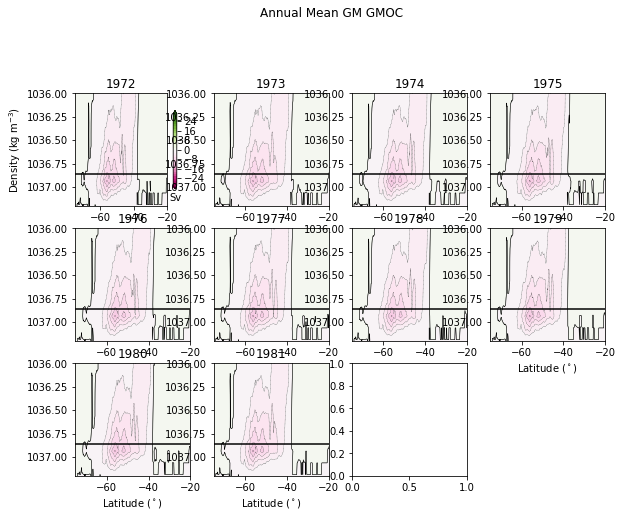

In [14]:
#plot GM gmoc in rho space
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Annual Mean GMOC Net')
clev = np.arange(-30,32,2)

t1=0
t2=5

plt.subplot(541)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0)+np.mean(cntrl_gmoc_gm[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0)+np.mean(cntrl_gmoc_gm[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0)+np.mean(cntrl_gmoc_gm[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.2,1036))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-75,-20])
tit='1972'
plt.title(tit)
plt.plot([-75,-20], [1036.86,1036.86], 'k')


ii=0
for yr in range(0,19):
    
    #np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0)
    plt.subplot(5,4,yr+2)
    p1=plt.contourf(yu_ocean,potrho,pert_gmoc_gm[yr,:,:],cmap=plt.cm.PiYG,levels=clev,extend='both')
    #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    #cb.ax.set_xlabel('Sv')
    plt.contour(yu_ocean,potrho,pert_gmoc_gm[yr,:,:],levels=clev,colors='k',linewidths=0.25)
    plt.contour(yu_ocean,potrho,pert_gmoc_gm[yr,:,:],levels=[0.0,],colors='k',linewidths=0.5)
    plt.gca().invert_yaxis()
    plt.gca().yaxis.set_major_formatter(x_formatter)
    plt.ylim((1037.2,1036))
    #plt.ylabel('Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$)')
    plt.xlim([-75,-20])
    tit=yrs[yr].astype('S4')
    plt.title(yrs[yr])
    plt.plot([-75,-20], [1036.86,1036.86], 'k')


ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Sv')

#of = os.path.join(NYFPertDir,'wpm2_cn.pdf')
#print of
#plt.savefig(of)
#of = os.path.join(NYFPertDir,'wpm2_cn.png')
#plt.savefig(of,dpi=220)
#of = os.path.join(NYFPertDir,'gmoc.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'gmoc_net.png')
plt.savefig(of,dpi=220)

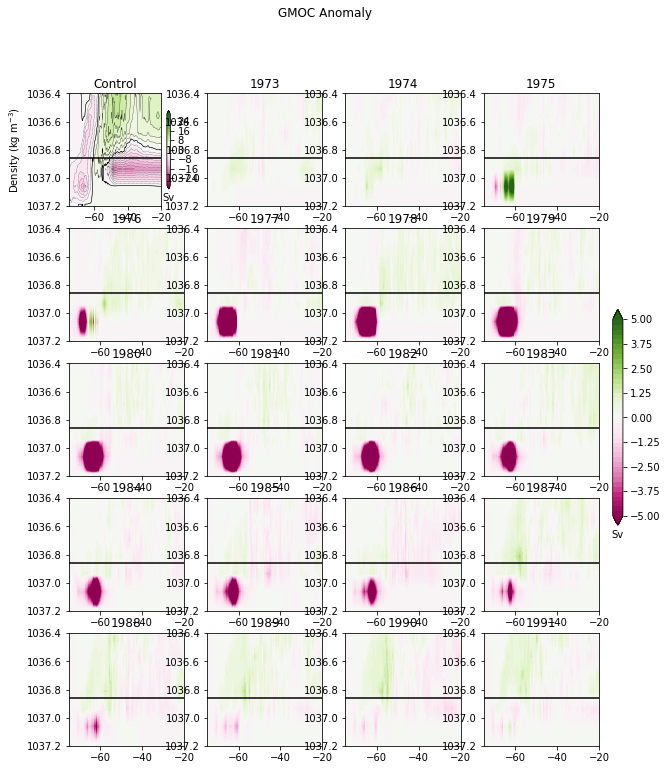

In [29]:
#plot gmoc anom in rho space
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('GMOC Net Anomaly')

clev = np.arange(-30,32,2)

t1=0
t2=5

plt.subplot(541)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_gmoc_gm[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc_gm[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc_gm[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.2,1036.4))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-75,-20])
tit='Control'
plt.title(tit)
plt.plot([-75,-20], [1036.86,1036.86], 'k')

yrs=np.arange(1973,2016,1)

ii=0

clev = np.arange(-5,5.25,0.25)


for yr in range(0,19):
    
    #np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0)
    plt.subplot(5,4,yr+2)
    p1=plt.contourf(yu_ocean,potrho,pert_gmoc_gm[yr,:,:]-np.mean(cntrl_gmoc[:,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
    #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    #cb.ax.set_xlabel('Sv')
    #plt.contour(yu_ocean,potrho,pert_gmoc[yr,:,:]-cntrl_gmoc[yr,:,:],levels=clev,colors='k',linewidths=0.25)
    #plt.contour(yu_ocean,potrho,pert_gmoc[yr,:,:]-cntrl_gmoc[yr,:,:],levels=[0.0,],colors='k',linewidths=0.5)
    plt.gca().invert_yaxis()
    plt.gca().yaxis.set_major_formatter(x_formatter)
    plt.ylim((1037.2,1036.4))
    #plt.ylabel('Density (kg m$^{-3}$)')
    #plt.xlabel('Latitude ($^\circ$)')
    plt.xlim([-75,-20])
    tit='Anom. ' + yrs[yr].astype('S4')
    plt.title(yrs[yr].astype('S4'))
    plt.plot([-75,-20], [1036.86,1036.86], 'k')

    
ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Sv')

#of = os.path.join(NYFPertDir,'wpm2_cn.pdf')
#print of
#plt.savefig(of)
#of = os.path.join(NYFPertDir,'wpm2_cn.png')
#plt.savefig(of,dpi=220)
#of = os.path.join(NYFPertDir,'gmoc_anom.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'gmoc_net_anom.png')
plt.savefig(of,dpi=220)

(50,)
29


/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:51: VisibleDeprecationWarning:

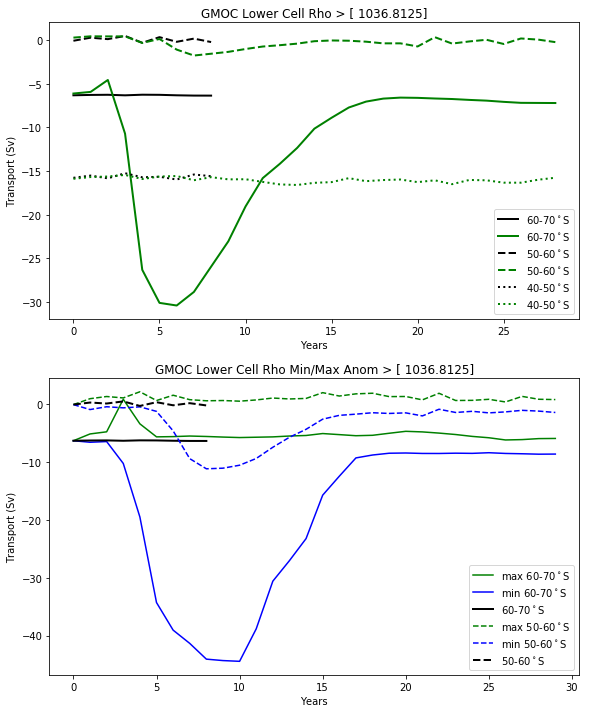

In [30]:
#plot time series of AABW
T=np.arange(50)
print T.shape


z1=np.argwhere(potrho<1036.86)
z1=z1[-1]

ts=pert_gmoc.shape
ts=ts[0]
print ts

# do lower cell average between lats 60-65S
j1=np.argwhere(yt_ocean<-69.9)
j2=np.argwhere(yt_ocean<-60)
j1=j1[-1]
j2=j2[-1]

lc_cntrl60_psj = cntrl_gmoc[:,z1:,j1:j2]
lc_cntrl60_psj_bar = np.mean(lc_cntrl60_psj,2)
lc_cntrl60_psj_ts = np.min(lc_cntrl60_psj_bar,1)

lc_pert60_psj = pert_gmoc[:,z1:,j1:j2]
lc_pert60_psj_bar = np.mean(lc_pert60_psj,2)
lc_pert60_psj_ts = np.min(lc_pert60_psj_bar,1)

lc_anom60_psj = pert_gmoc[0:ts,z1:,j1:j2]-np.mean(cntrl_gmoc[:,z1:,j1:j2],axis=0)
lc_max_anom60_psj_ts = np.max(lc_anom60_psj,1)
lc_max_anom60_psj_ts = np.max(lc_max_anom60_psj_ts,1)
lc_max_anom60_psj_ts=np.insert(lc_max_anom60_psj_ts,0,0)
lc_max60_ts = lc_max_anom60_psj_ts + lc_cntrl60_psj_ts[0]

lc_min_anom60_psj_ts = np.min(lc_anom60_psj,1)
lc_min_anom60_psj_ts = np.min(lc_min_anom60_psj_ts,1)
lc_min_anom60_psj_ts=np.insert(lc_min_anom60_psj_ts,0,0)
lc_min60_ts = lc_min_anom60_psj_ts + lc_cntrl60_psj_ts[0]

#print lc_max_ts
#print lc_min_ts

# do lower cell average between lats 40-45S
j1=np.argwhere(yt_ocean<-49.9)
j2=np.argwhere(yt_ocean<-40)
j1=j1[-1]
j2=j2[-1]

lc_cntrl40_psj = cntrl_gmoc[:,z1:,j1:j2]
lc_cntrl40_psj_bar = np.mean(lc_cntrl40_psj,2)
lc_cntrl40_psj_ts = np.min(lc_cntrl40_psj_bar,1)

lc_pert40_psj = pert_gmoc[:,z1:,j1:j2]
lc_pert40_psj_bar = np.mean(lc_pert40_psj,2)
lc_pert40_psj_ts = np.min(lc_pert40_psj_bar,1)

lc_anom40_psj = pert_gmoc[0:ts,z1:,j1:j2]-np.mean(cntrl_gmoc[:,z1:,j1:j2],axis=0)

lc_max_anom40_psj_ts = np.max(lc_anom40_psj,1)
lc_max_anom40_psj_ts = np.max(lc_max_anom40_psj_ts,1)
lc_max_anom40_psj_ts=np.insert(lc_max_anom40_psj_ts,0,0)
lc_max40_ts = lc_max_anom40_psj_ts + lc_cntrl40_psj_ts[0]

lc_min_anom40_psj_ts = np.min(lc_anom40_psj,1)
lc_min_anom40_psj_ts = np.min(lc_min_anom40_psj_ts,1)
lc_min_anom40_psj_ts=np.insert(lc_min_anom40_psj_ts,0,0)
lc_min40_ts = lc_min_anom40_psj_ts + lc_cntrl40_psj_ts[0]

# do lower cell average between lats 20-25S
j1=np.argwhere(yt_ocean<-59.9)
j2=np.argwhere(yt_ocean<-50)
j1=j1[-1]
j2=j2[-1]

lc_cntrl50_psj = cntrl_gmoc[:,z1:,j1:j2]
lc_cntrl50_psj_bar = np.mean(lc_cntrl50_psj,2)
lc_cntrl50_psj_ts = np.min(lc_cntrl50_psj_bar,1)

lc_pert50_psj = pert_gmoc[:,z1:,j1:j2]
lc_pert50_psj_bar = np.mean(lc_pert50_psj,2)
lc_pert50_psj_ts = np.min(lc_pert50_psj_bar,1)

lc_anom50_psj = pert_gmoc[0:ts,z1:,j1:j2]-np.mean(cntrl_gmoc[:,z1:,j1:j2],axis=0)

lc_max_anom50_psj_ts = np.max(lc_anom50_psj,1)
lc_max_anom50_psj_ts = np.max(lc_max_anom50_psj_ts,1)
lc_max_anom50_psj_ts=np.insert(lc_max_anom50_psj_ts,0,0)
lc_max50_ts = lc_max_anom50_psj_ts + lc_cntrl50_psj_ts[0]

lc_min_anom50_psj_ts = np.min(lc_anom50_psj,1)
lc_min_anom50_psj_ts = np.min(lc_min_anom50_psj_ts,1)
lc_min_anom50_psj_ts=np.insert(lc_min_anom50_psj_ts,0,0)
lc_min50_ts = lc_min_anom50_psj_ts + lc_cntrl50_psj_ts[0]

plt.subplot(211)
plt.plot(lc_cntrl60_psj_ts,linestyle='-',color='k',label='60-70$^\circ$S',linewidth=2)
plt.plot(lc_pert60_psj_ts,linestyle='-',color='g',label='60-70$^\circ$S',linewidth=2)
plt.plot(lc_cntrl50_psj_ts,linestyle='--',color='k',label='50-60$^\circ$S',linewidth=2)
plt.plot(lc_pert50_psj_ts,linestyle='--',color='g',label='50-60$^\circ$S',linewidth=2)
plt.plot(lc_cntrl40_psj_ts,linestyle=':',color='k',label='40-50$^\circ$S',linewidth=2)
plt.plot(lc_pert40_psj_ts,linestyle=':',color='g',label='40-50$^\circ$S',linewidth=2)
#plt.plot(lc_max40_ts,linestyle=':',color='g',linewidth=1.5)
#plt.plot(lc_min40_ts,linestyle=':',color='b',linewidth=1.5)
#plt.plot(lc_cntrl40_psj_ts,linestyle=':',color='k',label='40-50$^\circ$S',linewidth=2)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
tit='GMOC Lower Cell Rho > ' +str(potrho[z1])
plt.title(tit)
plt.legend(fontsize=10)

plt.subplot(212)
plt.plot(lc_max60_ts,linestyle='-',color='g',label='max 60-70$^\circ$S',linewidth=1.5)
plt.plot(lc_min60_ts,linestyle='-',color='b',label='min 60-70$^\circ$S',linewidth=1.5)
plt.plot(lc_cntrl60_psj_ts,linestyle='-',color='k',label='60-70$^\circ$S',linewidth=2)
plt.plot(lc_max50_ts,linestyle='--',label='max 50-60$^\circ$S',color='g',linewidth=1.5)
plt.plot(lc_min50_ts,linestyle='--',label='min 50-60$^\circ$S',color='b',linewidth=1.5)
plt.plot(lc_cntrl50_psj_ts,linestyle='--',color='k',label='50-60$^\circ$S',linewidth=2)
#plt.plot(lc_max40_ts,linestyle=':',color='g',linewidth=1.5)
#plt.plot(lc_min40_ts,linestyle=':',color='b',linewidth=1.5)
#plt.plot(lc_cntrl40_psj_ts,linestyle=':',color='k',label='40-50$^\circ$S',linewidth=2)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
tit='GMOC Lower Cell Rho Min/Max Anom > ' +str(potrho[z1])
plt.title(tit)
plt.legend(fontsize=10)

#of = os.path.join(NYFPertDir,'gmoc_ts.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'gmoc_ts.png')
plt.savefig(of,dpi=220)

In [31]:
#calc tx transport, acc transport
cntrl_psi=cntrl.tx_trans[:,:,:,:].sum('st_ocean').cumsum('yt_ocean').load()
print cntrl_psi.shape

of=os.path.join(NYFCntrlDir,'psi.npy')
a=np.save(of,cntrl_psi)


#pert_psi=ff.tx_trans[:,:,:,:].sum('st_ocean').cumsum('yt_ocean').load()


(9, 1080, 1440)


In [32]:
#calc tx transport, acc transport
pert_psi=pert.tx_trans[:,:,:,:].sum('st_ocean').cumsum('yt_ocean').load()
print pert_psi.shape

of=os.path.join(NYFPertDir,'psi.npy')
a=np.save(of,pert_psi)



(29, 1080, 1440)


In [33]:
#load acc psi
of=os.path.join(NYFPertDir,'psi.npy')
pert_psi=np.load(of)
print pert_psi.shape

#of=os.path.join(NYFCntrlDir,'cntrl_gmocs.npy')
of=os.path.join(NYFCntrlDir,'psi.npy')
cntrl_psi=np.load(of)
print cntrl_psi.shape

(29, 1080, 1440)
(9, 1080, 1440)


[-200. -180. -160. -140. -120. -100.  -80.  -60.  -40.  -20.    0.   20.
   40.   60.   80.  100.  120.  140.  160.  180.  200.]
[1000 2000 3000 4000 5000]
[1000 2000 3000 4000 5000]


Text(0.5,1,u'Control Bathy')

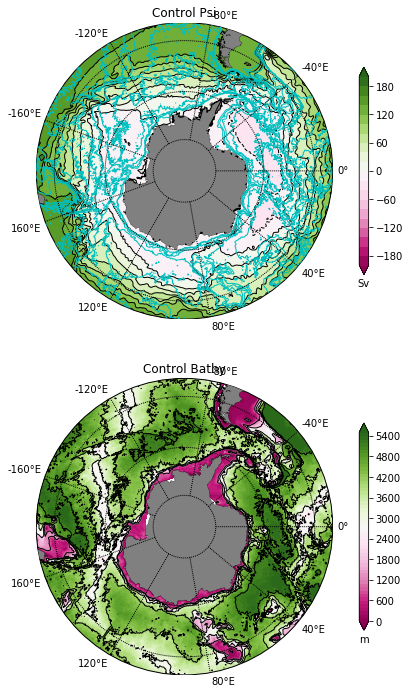

In [34]:
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plot ACC transport
clev = np.linspace(-200,200,21)
print clev

plt.subplot(2,1,1)
map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,np.mean(cntrl_psi[0:5],axis=0), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
#clev3 = np.arange(0,200,20)
#print clev3
map.contour(X,Y,np.mean(cntrl_psi[0:5],axis=0),levels=clev,colors='k',linewidths=1)

clev3 = np.arange(1000,5001,1000)
print clev3
map.contour(X,Y,ht[:,:],levels=clev3,colors='c',linewidths=1)    

plt.title('Control Psi')

plt.subplot(2,1,2)
map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
clev3 = np.arange(0,5600,100)
p1=map.contourf(X,Y,ht[:,:], cmap=plt.cm.PiYG, levels=clev3, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('m')
#clev3 = np.arange(0,200,20)
#print clev3

clev3 = np.arange(1000,5001,1000)
print clev3
map.contour(X,Y,ht[:,:],levels=clev3,colors='k',linewidths=1)    

plt.title('Control Bathy')


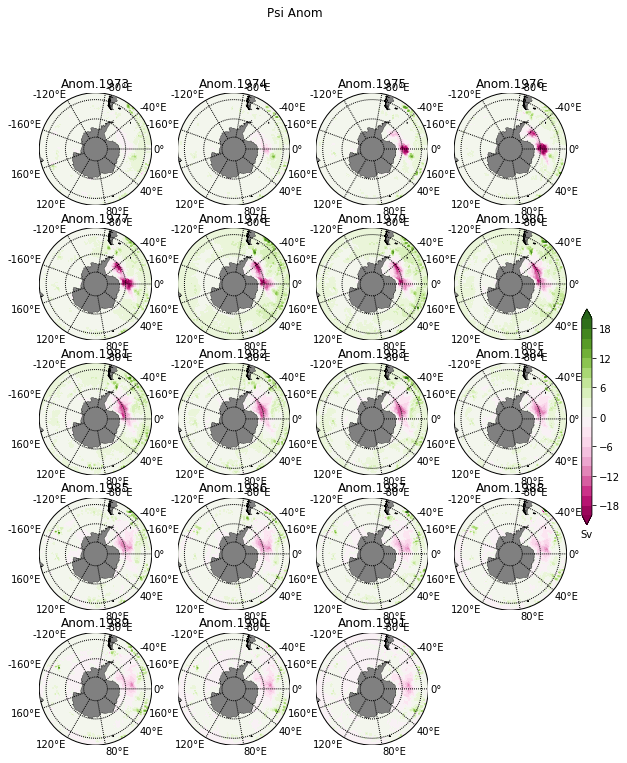

In [36]:
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Psi Anom')
#plot ACC transport
yrs=np.arange(1973,2016,1)

ii=0


clev = np.linspace(-20,20,21)

for yr in range(0,19):
    
    #np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0)
    plt.subplot(5,4,yr+1)
    map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    map.drawparallels(np.arange(-80.,81.,15.))
    map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
    X, Y = map(geolon_t,geolat_t) 
    p1=map.contourf(X,Y,pert_psi[yr,:,:]-np.mean(cntrl_psi[:,:,:],axis=0), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
    #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    #cb.ax.set_xlabel('Sv')
    #clev3 = np.arange(0,200,20)
    #print clev3
    #map.contour(X,Y,np.mean(cntrl_psi[0:5],axis=0),levels=clev,colors='k',linewidths=1)
    
    tit='Anom.' + yrs[yr].astype('S4')
    plt.title(tit)
    
    
ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Sv')

#of = os.path.join(NYFPertDir,'wpm2_cn.pdf')
#print of
#plt.savefig(of)
#of = os.path.join(NYFPertDir,'wpm2_cn.png')
#plt.savefig(of,dpi=220)
#of = os.path.join(NYFPertDir,'gmoc_anom.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'psi_anom.png')
plt.savefig(of,dpi=220)

[1000 2000 3000 4000 5000]


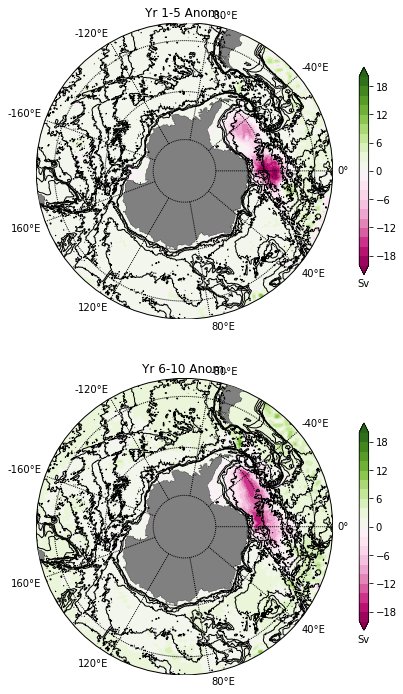

In [37]:
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.linspace(-20,20,21)

plt.subplot(2,1,1)
map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,np.mean(pert_psi[1:5],axis=0)-np.mean(cntrl_psi[5:9],axis=0), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#p1=map.contourf(X,Y,np.mean(pert_psi[0:5],axis=0)-np.mean(cntrl_psi[0:5],axis=0), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
#clev3 = np.arange(0,200,20)
#print clev3
#map.contour(X,Y,np.mean(pert_psi[0:5],axis=0)-np.mean(cntrl_psi[0:5],axis=0),levels=clev,colors='k',linewidths=1)
clev3 = np.arange(1000,5001,1000)
map.contour(X,Y,ht[:,:],levels=clev3,colors='k',linewidths=1)    
plt.title('Yr 1-5 Anom.')

#ax3 = plt.axes([0.92,0.38,0.015,0.25])
#cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#cb.ax.set_ylabel('Sv')

plt.subplot(2,1,2)
map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,np.mean(pert_psi[5:10],axis=0)-np.mean(cntrl_psi[5:9],axis=0), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
#clev3 = np.arange(0,200,20)
#print clev3
#map.contour(X,Y,np.mean(pert_psi[4:7],axis=0)-np.mean(cntrl_psi[4:7],axis=0),levels=clev,colors='k',linewidths=1)
clev3 = np.arange(1000,5001,1000)
print clev3
map.contour(X,Y,ht[:,:],levels=clev3,colors='k',linewidths=1)    
plt.title('Yr 6-10 Anom.')

#ax3 = plt.axes([0.92,0.38,0.015,0.25])
#cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#cb.ax.set_ylabel('Sv')

#of = os.path.join(NYFPertDir,'psi.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'psi_anom.png')
plt.savefig(of,dpi=220)

[1000 2000 3000 4000 5000]


Text(0.5,1,u'PSI Pert Yr 6-10 Anom.')

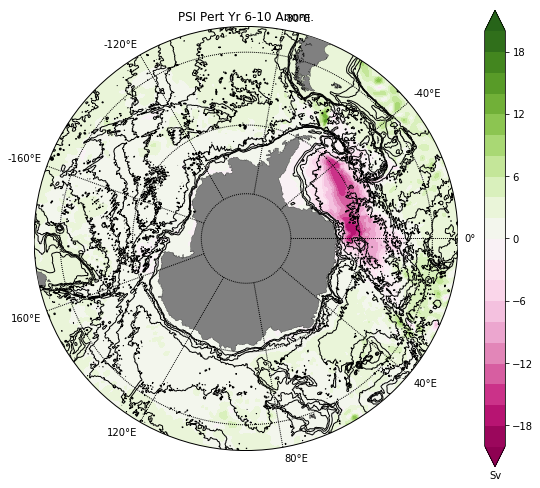

In [38]:
plt.subplot(1,1,1)
map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,np.mean(pert_psi[5:10],axis=0)-np.mean(cntrl_psi[5:9],axis=0), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
#clev3 = np.arange(0,200,20)
#print clev3
#map.contour(X,Y,np.mean(pert_psi[4:7],axis=0)-np.mean(cntrl_psi[4:7],axis=0),levels=clev,colors='k',linewidths=1)
clev3 = np.arange(1000,5001,1000)
print clev3
map.contour(X,Y,ht[:,:],levels=clev3,colors='k',linewidths=1)    
plt.title('PSI Pert Yr 6-10 Anom.')


In [39]:
# do psi max between lon 67-69S
i1=np.argwhere(xt_ocean<-69)
i2=np.argwhere(xt_ocean<-67)
i1=i1[-1]
i2=i2[-1]

j1=np.argwhere(yt_ocean<-54)
j1=j1[-1]

print j1, i1, i2

[239] [843] [851]


(50,)
[239] [843] [851]


/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


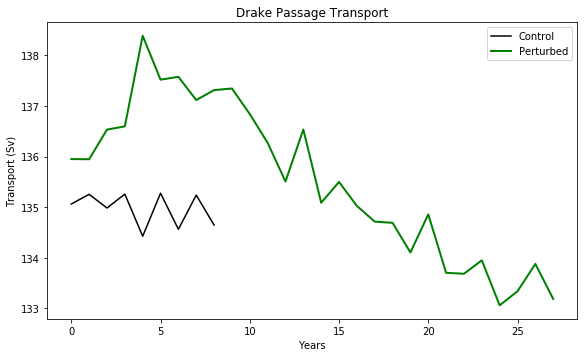

In [40]:
#plot Drake Passage time series
T=np.arange(50)
print T.shape

# do psi max between lon 67-69S
i1=np.argwhere(xt_ocean<-69)
i2=np.argwhere(xt_ocean<-67)
i1=i1[-1]
i2=i2[-1]

j1=np.argwhere(yt_ocean<-54)
j1=j1[-1]

print j1, i1, i2

cntrl_dp = cntrl_psi[:,0:j1,i1:i2]
cntrl_dp_bar = np.mean(cntrl_dp,2)
cntrl_dp_ts = np.max(cntrl_dp_bar,1)

pert_dp = pert_psi[1:,0:j1,i1:i2]
pert_dp_bar = np.mean(pert_dp,2)
pert_dp_ts = np.max(pert_dp_bar,1)

plt.subplot(211)
plt.plot(cntrl_dp_ts,linestyle='-',color='k',label='Control',linewidth=1.5)
plt.plot(pert_dp_ts,linestyle='-',color='g',label='Perturbed',linewidth=2)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
tit=('Drake Passage Transport')
plt.title(tit)
plt.legend(fontsize=10)


#of = os.path.join(NYFPertDir,'dp_ts.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'dp_ts.png')
plt.savefig(of,dpi=220)

In [41]:
#plot temp
print cntrl.temp.shape
print pert.temp.shape

(9, 50, 1080, 1440)
(29, 50, 1080, 1440)


[-2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9 -0.8 -0.7 -0.6
 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2. ]
55.8532485962


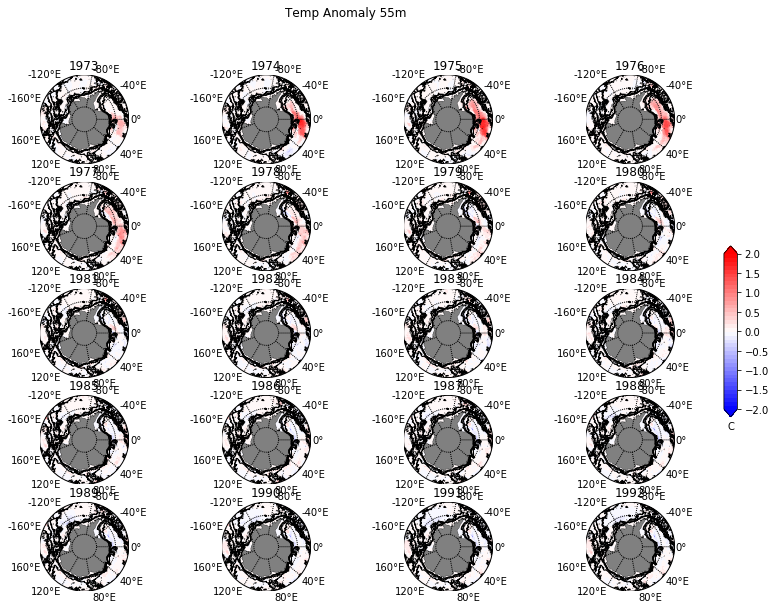

In [43]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Temp Anomaly 55m')
yrs=np.arange(1973,2016,1)

clev = np.linspace(-2,2,41)
print clev
st=5
print st_ocean[st]
ii=0
for yr in range(0,20):
    #print yr

    plt.subplot(5,4,yr+1)
    map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    map.drawparallels(np.arange(-80.,81.,15.))
    map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
    X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
    p1=map.contourf(X,Y,pert.temp[yr,st,0:500,:].load()-cntrl.temp[:,st,0:500,:].mean('time').load(), cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
    #cb=plt.colorbar(orientation='vertical',shrink = 0.5)
    #cb.ax.set_xlabel('N/m2')
    clev3 = np.arange(0,5000,1000)
    map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
    plt.title(yrs[yr].astype('S4'))

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('C')

#of = os.path.join(NYFPertDir,'temp_55m.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'temp_55m.png')
plt.savefig(of,dpi=220)



[-0.5   -0.475 -0.45  -0.425 -0.4   -0.375 -0.35  -0.325 -0.3   -0.275
 -0.25  -0.225 -0.2   -0.175 -0.15  -0.125 -0.1   -0.075 -0.05  -0.025  0.
  0.025  0.05   0.075  0.1    0.125  0.15   0.175  0.2    0.225  0.25
  0.275  0.3    0.325  0.35   0.375  0.4    0.425  0.45   0.475  0.5  ]
1497.56188965


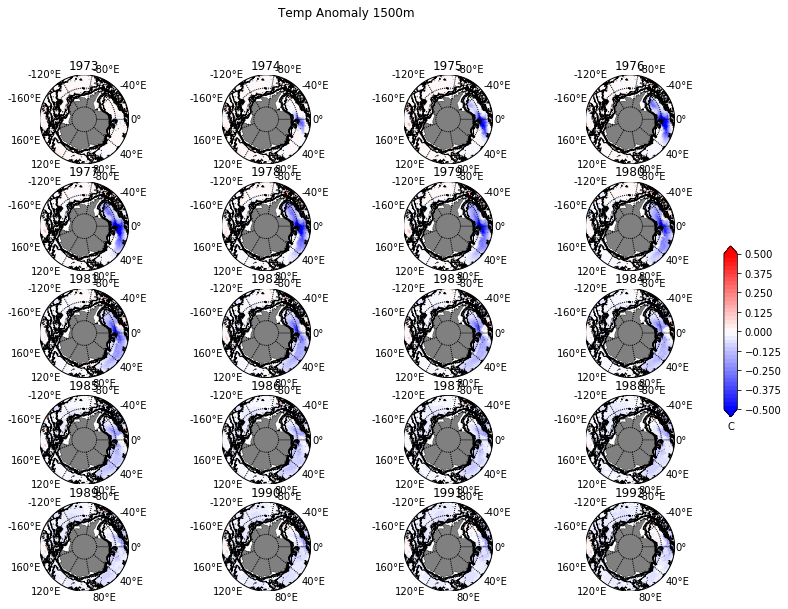

In [45]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Temp Anomaly 1500m')
yrs=np.arange(1973,2016,1)

clev = np.linspace(-.5,.5,41)
print clev
st=30
print st_ocean[st]
ii=0
for yr in range(0,20):
    #print yr

    plt.subplot(5,4,yr+1)
    map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    map.drawparallels(np.arange(-80.,81.,15.))
    map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
    X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
    p1=map.contourf(X,Y,pert.temp[yr,st,0:500,:].load()-cntrl.temp[:,st,0:500,:].mean('time').load(), cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
    #cb=plt.colorbar(orientation='vertical',shrink = 0.5)
    #cb.ax.set_xlabel('N/m2')
    clev3 = np.arange(0,5000,1000)
    map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
    plt.title(yrs[yr].astype('S4'))

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('C')

#of = os.path.join(NYFPertDir,'temp_1500m.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'temp_1500m.png')
plt.savefig(of,dpi=220)



[-0.5   -0.475 -0.45  -0.425 -0.4   -0.375 -0.35  -0.325 -0.3   -0.275
 -0.25  -0.225 -0.2   -0.175 -0.15  -0.125 -0.1   -0.075 -0.05  -0.025  0.
  0.025  0.05   0.075  0.1    0.125  0.15   0.175  0.2    0.225  0.25
  0.275  0.3    0.325  0.35   0.375  0.4    0.425  0.45   0.475  0.5  ]
3926.81274414


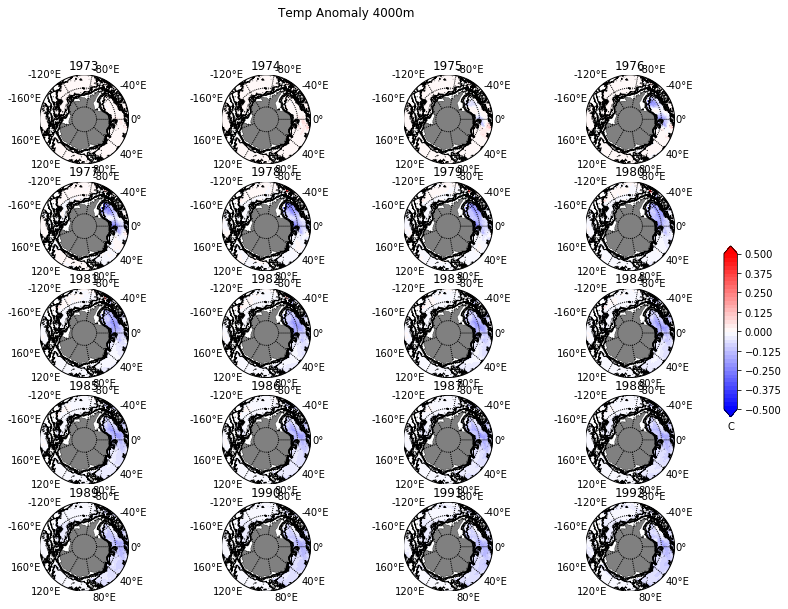

In [46]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Temp Anomaly 4000m')
yrs=np.arange(1973,2016,1)

clev = np.linspace(-.5,.5,41)
print clev
st=42
print st_ocean[st]
ii=0
for yr in range(0,20):
    #print yr

    plt.subplot(5,4,yr+1)
    map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    map.drawparallels(np.arange(-80.,81.,15.))
    map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
    X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
    p1=map.contourf(X,Y,pert.temp[yr,st,0:500,:].load()-cntrl.temp[:,st,0:500,:].mean('time').load(), cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
    #cb=plt.colorbar(orientation='vertical',shrink = 0.5)
    #cb.ax.set_xlabel('N/m2')
    clev3 = np.arange(0,5000,1000)
    map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
    plt.title(yrs[yr].astype('S4'))

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('C')

#of = os.path.join(NYFPertDir,'temp_4000m.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'temp_4000m.png')
plt.savefig(of,dpi=220)


In [47]:
print st_ocean[45]

4555.56591797


[-0.2  -0.18 -0.16 -0.14 -0.12 -0.1  -0.08 -0.06 -0.04 -0.02  0.    0.02
  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18  0.2 ]
1497.56188965


Text(0.5,1,u'Temp Anom at 1500m 1978')

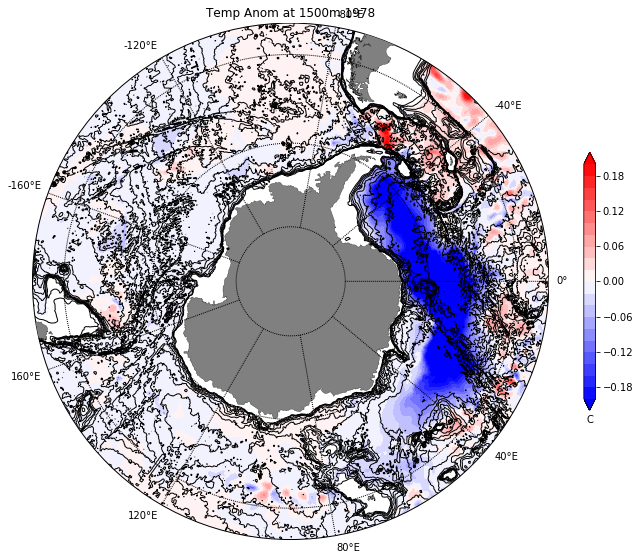

In [48]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.linspace(-.2,.2,21)
print clev
st=30
print st_ocean[st]
yr=5

plt.subplot(1,1,1)
map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
p1=map.contourf(X,Y,pert.temp[yr,st,0:500,:].load()-cntrl.temp[:,st,0:500,:].mean('time').load(), cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.5)
cb.ax.set_xlabel('C')
clev3 = np.arange(1000,5001,500)
map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('Temp Anom at 1500m ' + yrs[yr].astype('S4'))



#ax3 = plt.axes([0.92,0.38,0.015,0.25])
#cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
#cb.ax.set_xlabel('C')


[-0.5  -0.45 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05
  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5 ]
4555.56591797


Text(0.5,1,u'Temp Anom at 4500m 1978')

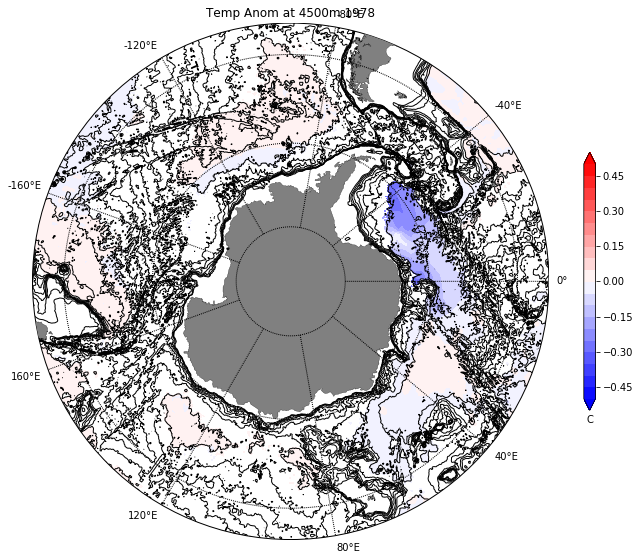

In [49]:
clev = np.linspace(-.5,.5,21)
print clev

st=45
print st_ocean[45]
yr=5

plt.subplot(1,1,1)
map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
p1=map.contourf(X,Y,pert.temp[yr,st,0:500,:].load()-cntrl.temp[yr,st,0:500,:].load(), cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.5)
cb.ax.set_xlabel('C')
clev3 = np.arange(1000,5001,500)
map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('Temp Anom at 4500m ' + yrs[yr].astype('S4'))
        
#ax3 = plt.axes([0.92,0.38,0.015,0.25])
#cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
#cb.ax.set_xlabel('C')

In [50]:
#calc zonal average temp anomalies
#Plot zonal average temp anomaly across weddell
x1=np.argwhere(xt_ocean<-40)
x2=np.argwhere(xt_ocean<15)
x1=x1[-1]
x2=x2[-1]

y1=np.argwhere(yt_ocean<-65)
#y2=np.argwhere(xt_ocean<15)
y1=y1[-1]
#y2=y2[-1]
print x1, x2

#print xt_ocean[x1:x2]
#print yt_ocean[:y1]


[959] [1179]


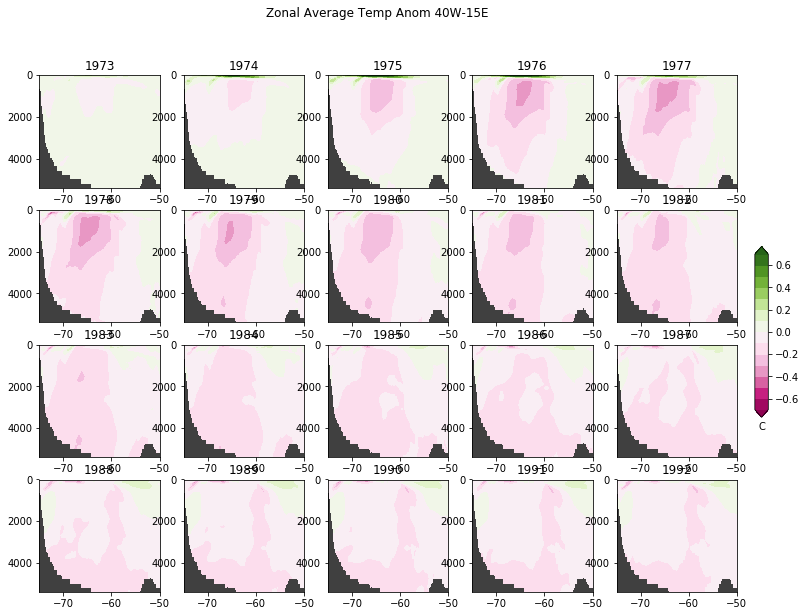

In [53]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Zonal Average Temp Anom 40W-15E')
#print cntrl.temp.shape
#print pert.temp.shape

#plt.subplot(211)
#clev = np.arange(-2,20,1)
#plt.contourf(yt_ocean[0:500],st_ocean,np.mean(cntrl_temp[:,:,x1:x2],axis=2),cmap=plt.cm.PiYG,levels=clev,extend='both')
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('Temp')
#plt.contour(yt_ocean[0:500],st_ocean,np.mean(cntrl_temp[:,:,x1:x2],axis=2),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,np.mean(cntrl_temp[:,:,x1:x2],axis=2),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
##plt.gca().yaxis.set_major_formatter(x_formatter)
##plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
#plt.xlim([-75,-50])
#plt.title('Control Temp')

ii=0
for yr in range(0,20):
    #print yr

    plt.subplot(4,5,yr+1)
    plt.gca().patch.set_color('.25')
    clev = np.arange(-.7,.71,0.1)
    p1=plt.contourf(yt_ocean[0:500],st_ocean,pert.temp[yr,:,0:500,x1:x2].mean('xt_ocean').load()-cntrl.temp[:,:,0:500,x1:x2].mean('time').mean('xt_ocean').load(),cmap=plt.cm.PiYG,levels=clev,extend='both')
    #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    #cb.ax.set_xlabel('kg/m3')
    #plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
    #plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
    plt.gca().invert_yaxis()
    #plt.gca().yaxis.set_major_formatter(x_formatter)
    #plt.ylim((1037.5,1034))
    #plt.ylabel('Depth (m)')
    #plt.xlabel('Latitude ($^\circ$S)')
    plt.xlim([-75,-50])
    plt.title(yrs[yr])
    #plt.title('40W to 15E Temp Anomaly 1976')

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('C')

#plt.subplot(224)
#plt.gca().patch.set_color('.25')
#clev = np.arange(-.5,.51,0.1)
#plt.contourf(yt_ocean[0:500],st_ocean,np.mean(pert_temp[9,:,:,:],axis=2)-np.mean(cntrl_temp[:,:,:],axis=2),cmap=plt.cm.PiYG,levels=clev,extend='both')
#plt.title('180W to 180E Temp Anomaly 1982')

#of = os.path.join(NYFPertDir,'zavTanom.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'zavTanom.png')
plt.savefig(of,dpi=220)

In [18]:
#store time-series between 60-65S at different depths
#pTz=np.zeros(pert_temp.shape[0],pert_temp.shape[1])
#cTz=np.zeros(pert_temp.shape[0],pert_temp.shape[1])
#print pTz.shape

x1=np.argwhere(xt_ocean<-40)
x2=np.argwhere(xt_ocean<15)
x1=x1[-1]
x2=x2[-1]

y1=np.argwhere(yt_ocean<-65)
y2=np.argwhere(yt_ocean<-60)
y1=y1[-1]
y2=y2[-1]
print x1, x2
print y1, y2

cTz=cntrl.temp[:,:,y1:y2,x1:x2].mean('yt_ocean').mean('xt_ocean').load()
print cTz.shape

pTz=pert.temp[:,:,y1:y2,x1:x2].mean('yt_ocean').mean('xt_ocean').load()
print pTz.shape

[959] [1179]
[152] [195]


/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/xarray/core/indexing.py:305: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  return None if value is None else operator.index(value)
/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


(9, 50)
(9, 50)


[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
(21,)
(50,)
(1, 50)
(30, 50)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
(20,)
(29, 50)
(29, 50)


Text(0.5,1,u'60-65S and 40W-15E Temp Anom')

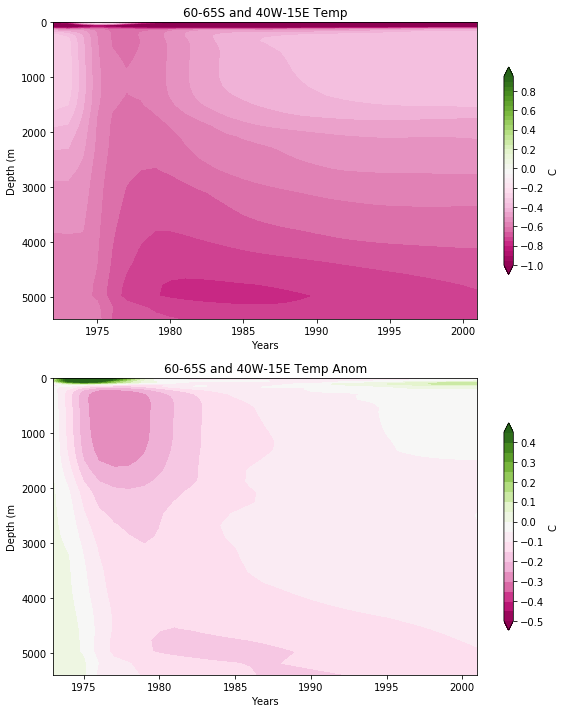

In [59]:
#plot temp hovmoeller of depth vs time
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

time = np.arange(-1,20,1)
print time
print time.shape

yrs=np.arange(1972,2016,1)

print cTz[0,:].shape
var1=np.expand_dims(cTz[0,:], axis=0)
print var1.shape
var2 = np.concatenate((var1,pTz),axis=0)
print var2.shape

clev = np.arange(-1,1,.05)
#print clev

plt.subplot(211)
plt.contourf(yrs[0:30],st_ocean,var2.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('C')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('60-65S and 40W-15E Temp')

clev = np.arange(-.5,.5,.05)
#print clev

time = np.arange(0,20,1)
print time
print time.shape
print pTz.shape
a=pTz-np.mean(cTz,axis=0)
print a.shape


plt.subplot(212)
plt.contourf(yrs[1:30],st_ocean,a.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('C')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('60-65S and 40W-15E Temp Anom')

In [60]:
#plot density
print cntrl.pot_rho_0.shape
print pert.pot_rho_0.shape


(9, 50, 1080, 1440)
(29, 50, 1080, 1440)


[-0.02  -0.018 -0.016 -0.014 -0.012 -0.01  -0.008 -0.006 -0.004 -0.002  0.
  0.002  0.004  0.006  0.008  0.01   0.012  0.014  0.016  0.018  0.02 ]
55.8532485962
3926.81274414


Text(0.5,1,u'Anom at 4000m 1978')

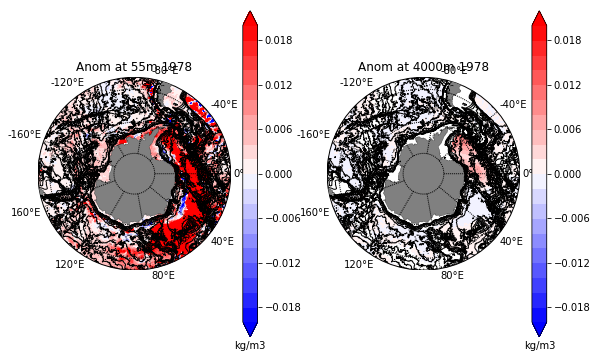

In [61]:
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.linspace(-.02,.02,21)
print clev
print st_ocean[5]
yr=5
yrs=np.arange(1973,2016,1)

plt.subplot(1,2,1)
map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
p1=map.contourf(X,Y,pert.pot_rho_0[yr,5,0:500,:].load()-cntrl.pot_rho_0[yr,5,0:500,:].load(), cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.5)
cb.ax.set_xlabel('kg/m3')
clev3 = np.arange(1000,5001,500)
map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('Anom at 55m ' + yrs[yr].astype('S4'))

print st_ocean[42]

plt.subplot(1,2,2)
map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
p1=map.contourf(X,Y,pert.pot_rho_0[yr,42,0:500,:].load()-cntrl.pot_rho_0[yr,42,0:500,:].load(), cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.5)
cb.ax.set_xlabel('kg/m3')
clev3 = np.arange(1000,5001,500)
map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('Anom at 4000m ' + yrs[yr].astype('S4'))
    
#ax3 = plt.axes([0.92,0.38,0.015,0.25])
#cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
#cb.ax.set_xlabel('C')

In [62]:
#calc zonal average anomalies
#Plot zonal average anomaly across weddell
x1=np.argwhere(xt_ocean<-40)
x2=np.argwhere(xt_ocean<15)
x1=x1[-1]
x2=x2[-1]

y1=np.argwhere(yt_ocean<-65)
#y2=np.argwhere(xt_ocean<15)
y1=y1[-1]
#y2=y2[-1]
print x1, x2

#print xt_ocean[x1:x2]
#print yt_ocean[:y1]


[959] [1179]


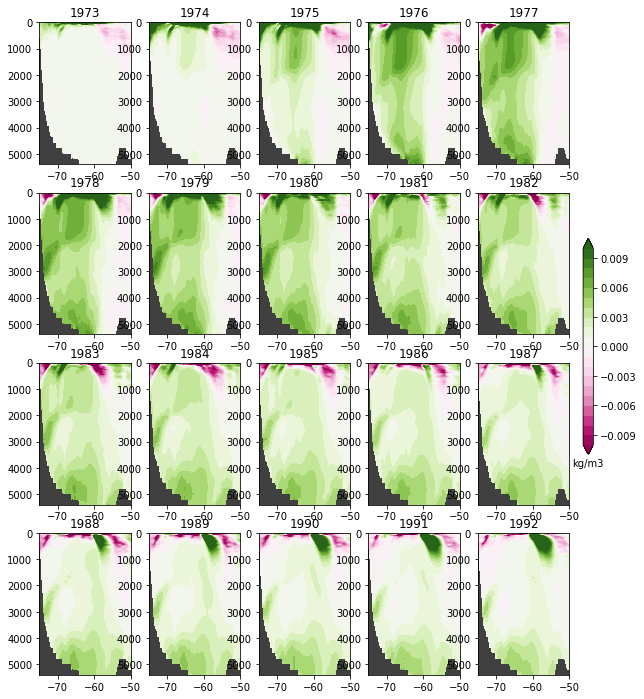

In [64]:
var2=cntrl.pot_rho_0[:,:,0:500,x1:x2].mean('time').mean('xt_ocean').load()

ii=0
for yr in range(0,20):
    #print yr
    var1=pert.pot_rho_0[yr,:,0:500,x1:x2].mean('xt_ocean').load()
    #print var1.shape, var2.shape
    
    plt.subplot(4,5,yr+1)
    plt.gca().patch.set_color('.25')
    clev = np.linspace(-.01,.01,21)
    
    p1=plt.contourf(yt_ocean[0:500],st_ocean,var1-var2,cmap=plt.cm.PiYG,levels=clev,extend='both')
    #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    #cb.ax.set_xlabel('kg/m3')
    #plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
    #plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
    plt.gca().invert_yaxis()
    #plt.gca().yaxis.set_major_formatter(x_formatter)
    #plt.ylim((1037.5,1034))
    #plt.ylabel('Depth (m)')
    #plt.xlabel('Latitude ($^\circ$S)')
    plt.xlim([-75,-50])
    plt.title(yrs[yr])
    #plt.title('40W to 15E Temp Anomaly 1976')

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('kg/m3')

#plt.subplot(224)
#plt.gca().patch.set_color('.25')
#clev = np.arange(-.5,.51,0.1)
#plt.contourf(yt_ocean[0:500],st_ocean,np.mean(pert_temp[9,:,:,:],axis=2)-np.mean(cntrl_temp[:,:,:],axis=2),cmap=plt.cm.PiYG,levels=clev,extend='both')
#plt.title('180W to 180E Temp Anomaly 1982')

#of = os.path.join(NYFPertDir,'zavTanom.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'zavRhoanom.png')
plt.savefig(of,dpi=220)

In [19]:
#store time-series between 60-65S at different depths
#pTz=np.zeros(pert_temp.shape[0],pert_temp.shape[1])
#cTz=np.zeros(pert_temp.shape[0],pert_temp.shape[1])
#print pTz.shape

x1=np.argwhere(xt_ocean<-40)
x2=np.argwhere(xt_ocean<15)
x1=x1[-1]
x2=x2[-1]

y1=np.argwhere(yt_ocean<-65)
y2=np.argwhere(yt_ocean<-60)
y1=y1[-1]
y2=y2[-1]
print x1, x2
print y1, y2

#cntrl_ztemp=ff.temp[0:5,:,0:500,859:1279].mean('time').mean('xt_ocean').load()
#need to area average this ...
cTz=cntrl.pot_rho_0[:,:,y1:y2,x1:x2].mean('yt_ocean').mean('xt_ocean').load()
print cTz.shape

#pert_ztemp=ff.temp[0:5,:,0:500,859:1279].mean('time').mean('xt_ocean').load()
#print pert_ztemp.shape

pTz=pert.pot_rho_0[:,:,y1:y2,x1:x2].mean('yt_ocean').mean('xt_ocean').load()
print pTz.shape

[959] [1179]
[152] [195]
(9, 50)
(9, 50)


[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
(21,)
(50,)
(1, 50)
(30, 50)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
(20,)
(29, 50)
(29, 50)


Text(0.5,1,u'60-65S and 40W-15E Rho Anom')

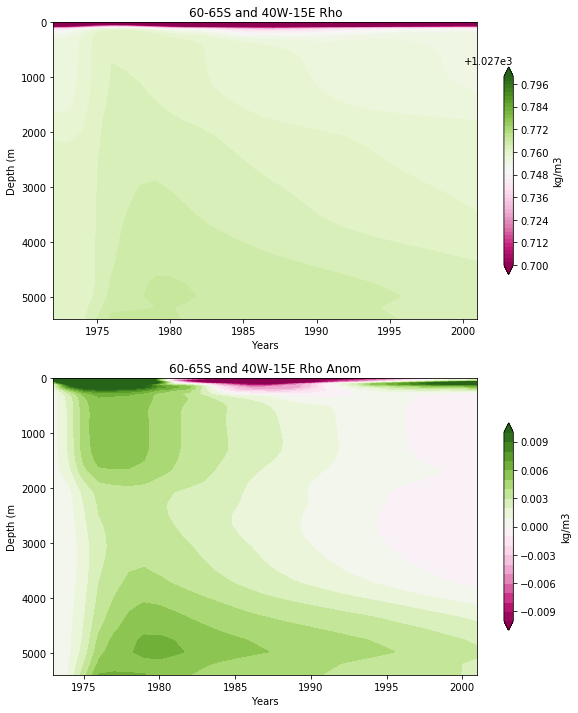

In [69]:
#plot rho hovmoeller of depth vs time
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

time = np.arange(-1,20,1)
print time
print time.shape

yrs=np.arange(1972,2016,1)

print cTz[0,:].shape
cn1=np.expand_dims(cTz[0,:], axis=0)
print cn1.shape
cn = np.concatenate((cn1,pTz),axis=0)
print cn.shape

clev = np.linspace(1027.7,1027.8,51)
#print clev

plt.subplot(211)
plt.contourf(yrs[0:30],st_ocean,cn.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('kg/m3')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('60-65S and 40W-15E Rho')

clev = np.linspace(-.01,.01,21)
#print clev

time = np.arange(0,20,1)
print time
print time.shape
print pTz.shape
a=pTz-np.mean(cTz,axis=0)
print a.shape


plt.subplot(212)
plt.contourf(yrs[1:30],st_ocean,a.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('kg/m3')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('60-65S and 40W-15E Rho Anom')

In [70]:
#calc zonal average anomalies
#Plot zonal average anomaly across weddell
x1=np.argwhere(xt_ocean<-40)
x2=np.argwhere(xt_ocean<15)
x1=x1[-1]
x2=x2[-1]

y1=np.argwhere(yt_ocean<-65)
#y2=np.argwhere(xt_ocean<15)
y1=y1[-1]
#y2=y2[-1]
print x1, x2

[959] [1179]


Text(0.5,1,u'Control Salt')

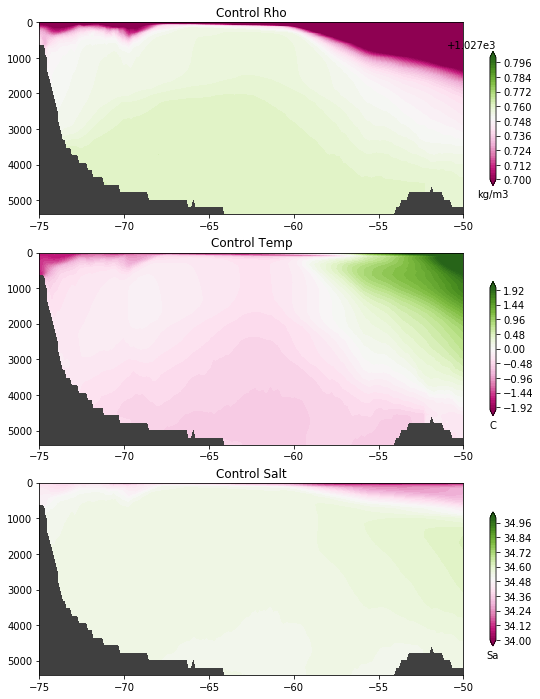

In [72]:
#plot control zavg temp, rho, salt 
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.title('Control Zavg Tracers 40W-15E')

yr=0
var1=cntrl.pot_rho_0[yr,:,0:500,x1:x2].mean('xt_ocean').load()

clev = np.linspace(1027.7,1027.8,51)

plt.subplot(3,1,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('Control Rho')

var1=cntrl.temp[yr,:,0:500,x1:x2].mean('xt_ocean').load()

clev = np.linspace(-2,2,51)

plt.subplot(3,1,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('C')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('Control Temp')

var1=cntrl.salt[yr,:,0:500,x1:x2].mean('xt_ocean').load()

clev = np.linspace(34,35,51)

plt.subplot(3,1,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sa')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('Control Salt')



In [33]:
#compare tracers to WOA13
#Ocean_File = '/g/data1/v45/pas561/mom/archive/woa13_mom025_ocean_temp_salt.res.nc'
#print Ocean_File
#woa=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
#print woa.temp.shape

nc = Dataset(file, mode='r') # file handle, open in read only mode
grid_xt = nc.variables['GRID_X_T'][:]
grid_yt = nc.variables['GRID_Y_T'][:]
zt = nc.variables['ZT'][:]
woa_temp = nc.variables['temp'][:]
woa_salt = nc.variables['salt'][:]
nc.close() # close the file

print woa_salt.shape, woa_temp.shape, grid_xt.shape, grid_yt.shape, zt.shape

woa_temp=np.squeeze(woa_temp)
woa_salt=np.squeeze(woa_salt)

print woa_salt.shape, woa_temp.shape


/g/data1/v45/pas561/mom/archive/woa13_mom025_ocean_temp_salt.res.nc
(1, 50, 1080, 1440)


In [28]:
#mask bathy 
#msk=ma.getmask(cntrl.temp[0].load())
msk=cntrl.temp[0].load()
print msk[:,500,500]
print woa_temp[:,500,500]


woa_temp[np.where(isnan(msk))]=nan
print woa_temp[:,500,500]
woa_salt[np.where(isnan(msk))]=nan
print woa_salt[:,500,500]

#woaT=numpy.ma.fix_invalid()
#msk[np.where(msk<-1)]=0
#msk[np.where(msk==-1)]=1


<xarray.DataArray 'temp' (st_ocean: 50)>
array([ 27.391373,  27.370281,  27.33518 ,  27.285015,  27.204884,  27.089434,
        26.876654,  26.565861,  25.865721,  24.812428,  23.600998,  21.820873,
        19.591003,  17.071674,  14.687031,  12.764536,  11.275241,  10.17234 ,
         9.40194 ,   8.853135,   8.389923,   7.868567,   7.334641,   6.811964,
         6.313274,   5.801466,   5.204368,   4.553436,   3.932255,   3.38131 ,
         2.965437,   2.637968,   2.373274,   2.158896,   1.967185,   1.801057,
         1.671383,   1.545439,   1.439953,   1.381891,   1.321449,   1.272832,
         1.231555,   1.187707,   1.099543,   1.060953,   1.045196,        nan,
              nan,        nan])
Coordinates:
    xt_ocean  float64 -154.9
    yt_ocean  float64 0.625
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 35.36 45.58 55.85 66.26 ...
Attributes:
    long_name:      Potential temperature
    units:          degrees C
    valid_range:    [ -10.  500.]
    cell_methods:   time: mea

In [30]:
#calc zonal average anomalies
#Plot zonal average anomaly across weddell
x1=np.argwhere(grid_xt<-40)
x2=np.argwhere(grid_xt<15)
x1=x1[-1]
x2=x2[-1]

y1=np.argwhere(grid_yt<-65)
#y2=np.argwhere(xt_ocean<15)
y1=y1[-1]
#y2=y2[-1]
print x1, x2, grid_xt[x1],grid_xt[x2], grid_yt[y1]



[959] [1179] [-40.125] [ 14.875] [-65.02601527]


/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:84: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


Text(0.5,1,u'Control Salt')

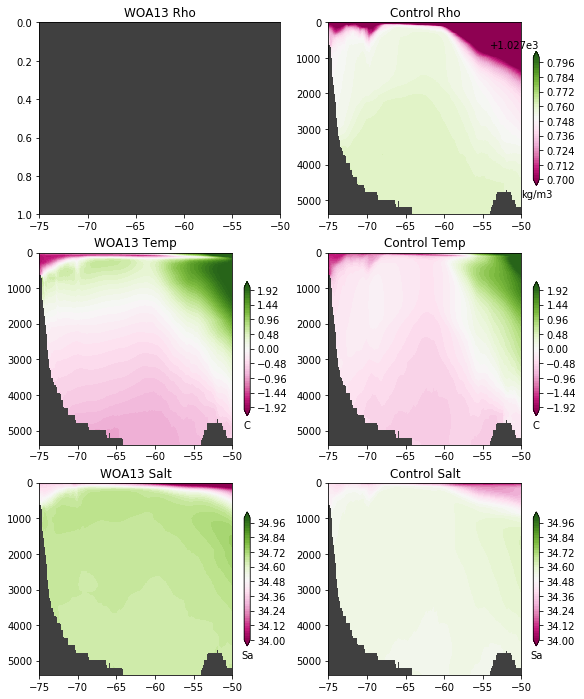

In [36]:
#plot control zavg temp, rho, salt 
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.title('WOA13 Zavg Tracers 40W-15E')

yr=0
var1=np.nanmean(woa_temp[:,0:500,x1:x2],axis=2)

clev = np.linspace(1027.7,1027.8,51)

plt.subplot(3,2,1)
plt.gca().patch.set_color('.25')
#p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('WOA13 Rho')

yr=0

var1=cntrl.pot_rho_0[yr,:,0:500,x1:x2].mean('xt_ocean').load()

plt.subplot(3,2,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('Control Rho')


var1=np.nanmean(woa_temp[:,0:500,x1:x2],axis=2)

clev = np.linspace(-2,2,51)

plt.subplot(3,2,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('C')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('WOA13 Temp')

var1=cntrl.temp[yr,:,0:500,x1:x2].mean('xt_ocean').load()

clev = np.linspace(-2,2,51)

plt.subplot(3,2,4)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('C')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('Control Temp')

var1=np.nanmean(woa_salt[:,0:500,x1:x2],axis=2)

clev = np.linspace(34,35,51)

plt.subplot(3,2,5)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sa')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('WOA13 Salt')

var1=cntrl.salt[yr,:,0:500,x1:x2].mean('xt_ocean').load()

clev = np.linspace(34,35,51)

plt.subplot(3,2,6)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sa')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('Control Salt')


In [ ]:
## Calc the AMOC from ty_trans for forcing cases

In [ ]:
#calculate the AMOC mask
#-1 is Atl and Arctic, all other ocean is -2, land is 0
#reset to 1 and 0
msk_file='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/basin_mask.nc'
nc = Dataset(msk_file, mode='r') # file handle, open in read only mode
msk= nc.variables['kmt'][:]
nc.close() # close the file
print msk.shape
msk[np.where(msk<-1)]=0
msk[np.where(msk==-1)]=1

clev = np.arange(-2,2,1)
print clev

plt.subplot(211)
plt.contourf(geolon_t,geolat_t,msk,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Mask')
plt.title('AMOC Mask')

In [ ]:
#do AMOC in zspace
Ocean_File = os.path.join(NYFCntrlDir,'output5*/ocean.nc')
print Ocean_File

ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.ty_trans.shape

#tt=ff.ty_trans[1,:,500,500].load()
#print 'no mask', tt

ty=ff.ty_trans*msk
print ty.shape
#tt=ty[1,:,500,500].load()
#print 'mask',tt

cntrl_amoc=ty[:,:,:,:].sum('xt_ocean').cumsum('st_ocean').load()

of=os.path.join(NYFCntrlDir,'amoc_z.npy')
a=np.save(of,cntrl_amoc)

In [ ]:
#do AMOC in zspace
Ocean_File = os.path.join(NYFPertDir,'output5*/ocean.nc')
print Ocean_File

ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.ty_trans.shape

#tt=ff.ty_trans[1,:,500,500].load()
#print 'no mask', tt

ty=ff.ty_trans*msk
print ty.shape
#tt=ty[1,:,500,500].load()
#print 'mask',tt

pert_amoc=ty[:,:,:,:].sum('xt_ocean').cumsum('st_ocean').load()

of=os.path.join(NYFPertDir,'amoc_z.npy')
a=np.save(of,pert_amoc)

In [ ]:
of=os.path.join(NYFPertDir,'amoc_z.npy')
pert_amoc=np.load(of)
print pert_amoc.shape

of=os.path.join(NYFCntrlDir,'amoc_z.npy')
cntrl_amoc=np.load(of)
print cntrl_amoc.shape


In [ ]:
#Amoc in Z space
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-20,22,2)

plt.subplot(221)
plt.contourf(yu_ocean,st_ocean,np.mean(cntrl_amoc,axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(cntrl_amoc,axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(cntrl_amoc,axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='Control Amoc'
plt.title(tit)

t1=0
t2=5

plt.subplot(222)
plt.contourf(yu_ocean,st_ocean,np.mean(pert_amoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='Perturbed AMOC Years '+str(t1)+'-'+str(t2)
plt.title(tit)

t1=0
t2=5

clev = np.arange(-5,6,.5)

plt.subplot(223)
plt.contourf(yu_ocean,st_ocean,np.mean(pert_amoc[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='AMOC Anom Years '+str(t1)+'-'+str(t2)
plt.title(tit)

t1=6
t2=10

plt.subplot(224)
plt.contourf(yu_ocean,st_ocean,np.mean(pert_amoc[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc,axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc,axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc,axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='AMOC Anom Years '+str(t1)+'-'+str(t2)
plt.title(tit)


In [ ]:
#plot time series of AMOC in z space
T=np.arange(14)
print T.shape


# do lower cell average between lats 55-60N
j1=np.argwhere(yt_ocean<55)
j2=np.argwhere(yt_ocean<60)
j1=j1[-1]
j2=j2[-1]

z1=np.argwhere(st_ocean<500)
z1=z1[-1]

uc_cntrl50_psj = cntrl_amoc[:,z1:,j1:j2]
uc_cntrl50_psj_bar = np.mean(uc_cntrl50_psj,2)
uc_cntrl50_psj_ts = np.max(uc_cntrl50_psj_bar,1)

uc_pert50_psj = pert_amoc[:,z1:,j1:j2]
uc_pert50_psj_bar = np.mean(uc_pert50_psj,2)
uc_pert50_psj_ts = np.max(uc_pert50_psj_bar,1)
uc_pert50_psj_ts=np.insert(uc_pert50_psj_ts,0,uc_cntrl50_psj_ts[0])


# do lower cell average between lats 40-45N
j1=np.argwhere(yt_ocean<30)
j2=np.argwhere(yt_ocean<35)
j1=j1[-1]
j2=j2[-1]

uc_cntrl40_psj = cntrl_amoc[:,z1:,j1:j2]
uc_cntrl40_psj_bar = np.mean(uc_cntrl40_psj,2)
uc_cntrl40_psj_ts = np.max(uc_cntrl40_psj_bar,1)

uc_pert40_psj = pert_amoc[:,z1:,j1:j2]
uc_pert40_psj_bar = np.mean(uc_pert40_psj,2)
uc_pert40_psj_ts = np.max(uc_pert40_psj_bar,1)
uc_pert40_psj_ts=np.insert(uc_pert40_psj_ts,0,uc_cntrl40_psj_ts[0])

# do lower cell average between lats 20-25N
j1=np.argwhere(yt_ocean<10)
j2=np.argwhere(yt_ocean<15)
j1=j1[-1]
j2=j2[-1]

uc_cntrl20_psj = cntrl_amoc[:,z1:,j1:j2]
uc_cntrl20_psj_bar = np.mean(uc_cntrl20_psj,2)
uc_cntrl20_psj_ts = np.max(uc_cntrl20_psj_bar,1)

uc_pert20_psj = pert_amoc[:,z1:,j1:j2]
uc_pert20_psj_bar = np.mean(uc_pert20_psj,2)
uc_pert20_psj_ts = np.max(uc_pert20_psj_bar,1)
uc_pert20_psj_ts=np.insert(uc_pert20_psj_ts,0,uc_cntrl20_psj_ts[0])


plt.subplot(211)
plt.plot(uc_pert50_psj_ts,linestyle='-',color='g',linewidth=1.5)
plt.plot(uc_cntrl50_psj_ts,linestyle='-',color='k',label='55-60$^\circ$N',linewidth=2)
plt.plot(uc_pert40_psj_ts,linestyle='--',color='g',linewidth=1.5)
plt.plot(uc_cntrl40_psj_ts,linestyle='--',color='k',label='30-35$^\circ$N',linewidth=2)
plt.plot(uc_pert20_psj_ts,linestyle=':',color='g',linewidth=1.5)
plt.plot(uc_cntrl20_psj_ts,linestyle=':',color='k',label='10-15$^\circ$N',linewidth=2)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
tit='AMOC Upper Cell Z > ' +str(st_ocean[z1])
plt.title(tit)
plt.legend(fontsize=10)

In [ ]:
print np.max(fh[540:1080,:])
print np.min(fh[540:1080,:])

In [ ]:
#Hov of Sea Ice Conc. in Southern Ocean
print xt_ocean[1040]
print xt_ocean[878]

Ocean_File = os.path.join(CntrlDir,'output5*/ice_month.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.CN.shape
nyf_cn=ff.CN[:,:,:,878:1040].sum('ct').mean('xt').load()
print nyf_cn.shape

Ocean_File = os.path.join(PertDir,'output*/ice_month.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.CN.shape
pert_cn=ff.CN[:,:,:,878:1040].sum('ct').mean('xt').load()
print pert_cn.shape


In [ ]:
print nyf_cn.shape
print pert_cn.shape
cn = np.concatenate((nyf_cn[0:12,:],pert_cn),axis=0)
print cn.shape

time = np.arange(-12,192,1)
#print time
print time.shape

print xt_ocean[1040]
print xt_ocean[878]

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.linspace(0,1.0,11)
print clev

plt.subplot(211)
plt.contourf(time,yt_ocean,cn.T,cmap=plt.cm.CMRmap_r,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('Concentration')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Months)')
#plt.xlim([-75,85])
plt.title('Strong/Shift Weddell Sea Sea Ice Concentration')